In [184]:
#(thlu = theta leg upper, thll = theta leg lower)


%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thlu,thll = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg_upper}','\\theta_{leg_lower}']) 
dx,dy,dthb,dthlu,dthll = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg_upper}','\dot{\\theta}_{leg_lower}']) 
ddx,ddy,ddthb,ddthlu,ddthll = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg_upper}','\ddot{\\theta}_{leg_lower}']) 

q = sym.Matrix([[x],[y],[thb],[thlu],[thll]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthlu],[dthll]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthlu],[ddthll]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tau_hip,tau_knee,GRFx,GRFy = sym.symbols(['\\tau_hip','\\tau_knee','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - 0.5*ll1*sym.cos(thb + thlu)],
                [y - 0.5*ll1*sym.sin(thb + thlu)],
                [thb + thlu]])

rl2 = sym.Matrix([[x - ll1*sym.cos(thb + thlu)+(0.5*ll2)*sym.sin(thb + thlu+thll)],
                [y - ll1*sym.sin(thb + thlu)-(0.5*ll2)*sym.cos(thb + thlu+thll)],
                [thb + thlu+thll]])



# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau_hip]])
tau_l1 = sym.Matrix([[0],[0],[tau_hip - tau_knee]])
tau_l2 = sym.Matrix([[0],[0],[tau_knee]])

# F_l1 = sym.Matrix([[-F*sym.sin(thb+thlu)],[F*sym.cos(thb+thlu)],[0]])
# F_l2 = sym.Matrix([[F*sym.sin(thb+thlu)],[-F*sym.cos(thb+thlu)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[0.5*ll2*GRFx*sym.cos(thb+thlu)+0.5*ll2*GRFy*sym.sin(thb+thlu)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1).transpose()*Jl1[:,j]+(GRF_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [185]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thlu,thll,
            dx,dy,dthb,dthlu,dthll,
            ddx,ddy,ddthb,ddthlu,ddthll,
            tau_hip,tau_knee,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thlu = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_thll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [186]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_lu','theta_ll'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)

In [187]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [188]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
#         L = 0.5*m.len[('leg',1)]  + 0.5*m.len[('leg',2)] # total leg length
#         thA = m.q[n,'theta_b'] + m.q[n,'theta_lu'] + m.q[n,'theta_ll'] # absolute leg angle
        return m.footp[n,dof] ==  m.q[n,'y'] - (m.len[('leg',1)]*sin(m.q[n,'theta_b'] + m.q[n,'theta_lu'])-(1*m.len[('leg',2)])*cos(m.q[n,'theta_b'] +m.q[n,'theta_lu']+ m.q[n,'theta_ll']))#m.q[n,'y'] - L*cos(thA)
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)

# lambdify the foot velocity
footx = sym.Matrix([x + (0.5*ll1+0.5*ll2)*sym.sin(thb + thlu + thll)])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

In [189]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [0,np.pi]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [-np.pi/2,np.pi/2]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_lu'].setlb(hip_bound[0])
    m.q[n,'theta_lu'].setub(hip_bound[1])
    m.q[n,'theta_ll'].setlb(hip_bound[0])
    m.q[n,'theta_ll'].setub(hip_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
m.tau_r1 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.tau_b = Var(m.N, bounds = (-2,2)) # actuator torque at knee
m.tau_r2 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque


m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# complementarity
def hip_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT angle
            return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_lu']-m.q[n+1,'theta_ll'])*m.tau_r1[n,'ng']
        else:
            return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_lu'] + m.q[n+1,'theta_ll']- m.hip_bound['lo'])*m.tau_r1[n,'ps']
    else:
        return Constraint.Skip
m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

def knee_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT distance
            return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] )*m.F_r[n,'ng']
        else:
            return m.joint_penalty[n,'knee',jc] == ( - m.knee_bound['lo'])*m.F_r[n,'ps']
    else:
        return Constraint.Skip
m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

#bound contact forces at last node
for sgn in signs:
    m.F_r[N,sgn].value = 0
    m.F_r[N,sgn].fixed = True

for sgn in signs:
    m.tau_r1[N,sgn].value = 0
    m.tau_r1[N,sgn].fixed = True
    m.tau_r2[N,sgn].value = 0
    m.tau_r2[N,sgn].fixed = True

In [195]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))       #time constraint
    penalty_sum = 0
#     for n in range(1,N+1):
#         for gc in ground_constraints:             #ground constraints
#             penalty_sum += m.ground_penalty[n,gc] #ground constraints
#         for jc in joint_constraints:              #hard stop constraints
#             for j in joints:                       #hard stop constraints
#                 penalty_sum += m.joint_penalty[n,j,jc] #hard stop constraints
    return T+1000*penalty_sum
m.Cost = Objective(rule = CostFun)

    'pyomo.core.base.objective.SimpleObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.SimpleObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [191]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thlu(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thlu(*var_list) == 0
m.EOM_thlu = Constraint(m.N, rule = EOM_thlu)

def EOM_thll(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thll(*var_list) == 0
m.EOM_thll = Constraint(m.N, rule = EOM_thll)

In [201]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 3.0
m.q[1,'theta_b'].value = 0.0
m.q[1,'theta_lu'].value = 0.0
m.q[1,'theta_ll'].value = 0.0

for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
    
for n in range(1,N+1):
    m.F_a[n].value = 0.0
    m.F_a[n].fixed = True
    m.tau_a[n].value = 0.0
    m.tau_a[n].fixed = True
    
m.q[N,'x'].value = 0.0
m.q[N,'y'].value = 0.0
m.q[N,'theta_b'].value = 0.0
m.q[N,'theta_lu'].value = 0.0
m.q[N,'theta_ll'].value = 0.0
    
m.pprint()


24 Set Declarations
    DOF : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'x', 'y', 'theta_b', 'theta_lu', 'theta_ll'}
    F_r_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :  N*sgn :  200 : {(1, 'ps'), (1, 'ng'), (2, 'ps'), (2, 'ng'), (3, 'ps'), (3, 'ng'), (4, 'ps'), (4, 'ng'), (5, 'ps'), (5, 'ng'), (6, 'ps'), (6, 'ng'), (7, 'ps'), (7, 'ng'), (8, 'ps'), (8, 'ng'), (9, 'ps'), (9, 'ng'), (10, 'ps'), (10, 'ng'), (11, 'ps'), (11, 'ng'), (12, 'ps'), (12, 'ng'), (13, 'ps'), (13, 'ng'), (14, 'ps'), (14, 'ng'), (15, 'ps'), (15, 'ng'), (16, 'ps'), (16, 'ng'), (17, 'ps'), (17, 'ng'), (18, 'ps'), (18, 'ng'), (19, 'ps'), (19, 'ng'), (20, 'ps'), (20, 'ng'), (21, 'ps'), (21, 'ng'), (22, 'ps'), (22, 'ng'), (23, 'ps'), (23, 'ng'), (24, 'ps'), (24, 'ng'), (25, 'ps'), (25, 'ng'), (26, 'ps'), (26, 'ng'), (27, 'ps'), (27, 'ng'), (28, 'ps'), (28, 'ng'), (29, 'ps')

             (75, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (75, 'Y') :   0.0 :  853.1878509748134 :  None : False : False :  Reals
         (76, 'THETA') :   0.0 :               None :  None : False :  True :  Reals
             (76, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (76, 'Y') :   0.0 :  867.4428118138193 :  None : False : False :  Reals
         (77, 'THETA') :   0.0 :               None :  None : False :  True :  Reals
             (77, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (77, 'Y') :   0.0 :  881.9299689514461 :  None : False : False :  Reals
         (78, 'THETA') :   0.0 :               None :  None : False :  True :  Reals
             (78, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (78, 'Y') :   0.0 :  896.9414177328722 :  None : False : False :  Reals
         (79, 'THETA') :   0.0 :               None :  None : Fal

          (61, 'theta_b') :  None :    -7.819267798620131 :              None : False : False :  Reals
         (61, 'theta_ll') :     0 :     0.740324793811312 : 3.141592653589793 : False : False :  Reals
         (61, 'theta_lu') :     0 :    1.1377688736858347 : 3.141592653589793 : False : False :  Reals
                (61, 'x') :  None :    -11.53377005579446 :              None : False : False :  Reals
                (61, 'y') :   0.0 :       648.97963581591 :              None : False : False :  Reals
          (62, 'theta_b') :  None :    -7.961255210660419 :              None : False : False :  Reals
         (62, 'theta_ll') :     0 :    0.7075212804943288 : 3.141592653589793 : False : False :  Reals
         (62, 'theta_lu') :     0 :    1.4552848200076791 : 3.141592653589793 : False : False :  Reals
                (62, 'x') :  None :   -11.660705120035628 :              None : False : False :  Reals
                (62, 'y') :   0.0 :     663.3051098201122 :              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key        : Lower : Body                                                                                                                                                                                                                                                                                        : Upper : Active
          (1, 'X') :   0.0 :                               footv[1,X,ps] - footv[1,X,ng] - (dq[1,x] + 0.5*dq[1,theta_lu]*cos(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + 0.5*dq[1,theta_ll]*cos(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + 0.5*dq[1,theta_b]*cos(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b])) :   0.0 :   True
          (2, 'X') :   0.0 :                               footv[2,X,ps] - footv[2,X,ng] - (dq[2,x] + 0.5*dq[2,theta_lu]*cos(q[2,theta_lu] + q[2,theta_ll] + q[2,theta_b]) + 0.5*dq[2,theta_ll]*cos(q[2,theta_lu] + q[2,theta_ll] + q[2,theta_b]) + 0.5*dq[2,theta_b]*cos(q[2,theta_lu] + q[2,theta_ll] + q[2,theta_b])) :   0.0 :   True
          

        Key : Lower : Body                                                        : Upper : Active
          1 :   0.0 :       ground_penalty[1,slip_ng] - footv[1,X,ng]*GRF[1,X,ng] :   0.0 :   True
          2 :   0.0 :       ground_penalty[2,slip_ng] - footv[2,X,ng]*GRF[2,X,ng] :   0.0 :   True
          3 :   0.0 :       ground_penalty[3,slip_ng] - footv[3,X,ng]*GRF[3,X,ng] :   0.0 :   True
          4 :   0.0 :       ground_penalty[4,slip_ng] - footv[4,X,ng]*GRF[4,X,ng] :   0.0 :   True
          5 :   0.0 :       ground_penalty[5,slip_ng] - footv[5,X,ng]*GRF[5,X,ng] :   0.0 :   True
          6 :   0.0 :       ground_penalty[6,slip_ng] - footv[6,X,ng]*GRF[6,X,ng] :   0.0 :   True
          7 :   0.0 :       ground_penalty[7,slip_ng] - footv[7,X,ng]*GRF[7,X,ng] :   0.0 :   True
          8 :   0.0 :       ground_penalty[8,slip_ng] - footv[8,X,ng]*GRF[8,X,ng] :   0.0 :   True
          9 :   0.0 :       ground_penalty[9,slip_ng] - footv[9,X,ng]*GRF[9,X,ng] :   0.0 :   True
         1

        (89, 'lo') :   0.0 :                       joint_penalty[89,hip,lo] - (q[90,theta_lu] + q[90,theta_ll])*tau_r1[89,ps] :   0.0 :   True
        (89, 'up') :   0.0 :   joint_penalty[89,hip,up] - (3.141592653589793 - q[90,theta_lu] - q[90,theta_ll])*tau_r1[89,ng] :   0.0 :   True
        (90, 'lo') :   0.0 :                       joint_penalty[90,hip,lo] - (q[91,theta_lu] + q[91,theta_ll])*tau_r1[90,ps] :   0.0 :   True
        (90, 'up') :   0.0 :   joint_penalty[90,hip,up] - (3.141592653589793 - q[91,theta_lu] - q[91,theta_ll])*tau_r1[90,ng] :   0.0 :   True
        (91, 'lo') :   0.0 :                       joint_penalty[91,hip,lo] - (q[92,theta_lu] + q[92,theta_ll])*tau_r1[91,ps] :   0.0 :   True
        (91, 'up') :   0.0 :   joint_penalty[91,hip,up] - (3.141592653589793 - q[92,theta_lu] - q[92,theta_ll])*tau_r1[91,ng] :   0.0 :   True
        (92, 'lo') :   0.0 :                       joint_penalty[92,hip,lo] - (q[93,theta_lu] + q[93,theta_ll])*tau_r1[92,ps] :   0.0 :   True

        Key               : Lower : Body                                                                : Upper : Active
           (2, 'theta_b') :   0.0 :          dq[2,theta_b] - (dq[1,theta_b] + 0.02*h[2]*ddq[1,theta_b]) :   0.0 :   True
          (2, 'theta_ll') :   0.0 :       dq[2,theta_ll] - (dq[1,theta_ll] + 0.02*h[2]*ddq[1,theta_ll]) :   0.0 :   True
          (2, 'theta_lu') :   0.0 :       dq[2,theta_lu] - (dq[1,theta_lu] + 0.02*h[2]*ddq[1,theta_lu]) :   0.0 :   True
                 (2, 'x') :   0.0 :                            dq[2,x] - (dq[1,x] + 0.02*h[2]*ddq[1,x]) :   0.0 :   True
                 (2, 'y') :   0.0 :                            dq[2,y] - (dq[1,y] + 0.02*h[2]*ddq[1,y]) :   0.0 :   True
           (3, 'theta_b') :   0.0 :          dq[3,theta_b] - (dq[2,theta_b] + 0.02*h[3]*ddq[2,theta_b]) :   0.0 :   True
          (3, 'theta_ll') :   0.0 :       dq[3,theta_ll] - (dq[2,theta_ll] + 0.02*h[3]*ddq[2,theta_ll]) :   0.0 :   True
          (3, 'theta_lu') :   0.

In [182]:
# # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# guide = np.linspace(0,5.0,N)
# for n in range(1,N+1):
#     m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#     m.q[n,'y'].value  = np.random.uniform(0,3)
#     m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/2,np.pi/2)
#     m.q[n,'theta_lu'].value  = np.random.uniform(0,np.pi)
#     m.q[n,'theta_ll'].value  = np.random.uniform(-np.pi/2,np.pi/2)
    
#     m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#     m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

In [166]:
# # SPRINT --------------------------------------------------------------------------------------------------------------------
# # tax day

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_lu'].value = np.pi/2
# m.q[1,'theta_ll'].value = 0.0

# m.q[1,'x'].fixed = True
# m.q[1,'theta_b'].fixed = True
# m.q[1,'theta_lu'].fixed = True
# m.q[1,'theta_ll'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
      
# # final condition
# m.q[N,'x'].setlb(5.0)

# m.dq[N,'x'].value = 0.0
# m.dq[N,'x'].fixed = 0.0
# m.dq[N,'theta_b'].value = 0.0
# m.dq[N,'theta_b'].fixed = 0.0
# m.dq[N,'theta_lu'].value = 0.0
# m.dq[N,'theta_lu'].fixed = 0.0
# m.dq[N,'theta_ll'].value = 0.0
# m.dq[N,'theta_ll'].fixed = 0.0

# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
# m.q[N,'theta_b'].fixed = True
# m.q[N,'theta_lu'].fixed = True
# m.q[N,'theta_ll'].fixed = True

# m.footp[N,'Y'].value = 0.0
# m.footp[N,'Y'].fixed = True
    
# #m.pprint()

In [202]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    15763
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6329

Total number of variables............................:     3776
                     variables with only lower bounds:     2185
                variables with lower and upper bounds:      398
                     variables with only 

 246r 8.3383785e+01 6.09e+01 4.41e+02  -4.3 4.95e+02  -3.3 9.19e-03 8.49e-02f  1
 247r 8.3388917e+01 5.32e+01 4.91e+02  -4.3 1.96e+02  -2.9 8.55e-01 1.52e-01f  1
 248r 8.3481607e+01 6.89e+01 3.85e+02  -4.3 5.71e+02  -3.4 5.67e-02 2.15e-01f  1
 249r 8.3541278e+01 6.73e+01 1.30e+02  -4.3 2.23e+02  -3.0 4.78e-02 7.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  8.3541325e+01 6.73e+01 1.55e+03  -1.0 4.02e+04    -  6.24e-04 1.63e-05f  1
 251  8.3544766e+01 6.73e+01 3.04e+02  -1.0 4.02e+04    -  4.82e-04 1.21e-03f  1
 252  8.3550962e+01 6.72e+01 1.52e+03  -1.0 3.98e+04    -  2.89e-03 2.18e-03f  1
 253  8.3573095e+01 6.72e+01 3.05e+02  -1.0 3.89e+04    -  7.20e-03 7.91e-03f  1
 254  8.3630528e+01 1.86e+02 1.25e+03  -1.0 3.64e+04    -  2.25e-02 2.19e-02f  1
 255  8.3770725e+01 1.11e+03 2.66e+03  -1.0 3.18e+04    -  6.20e-02 6.37e-02f  1
 256  8.4020201e+01 4.67e+03 1.06e+04  -1.0 2.71e+04    -  1.58e-01 1.62e-01f  1
 257  8.4514988e+01 4.95e+04

 340  8.0378753e+01 1.75e+03 2.21e+03  -2.5 1.82e+03  -7.8 4.51e-01 9.58e-01h  1
 341  8.0376141e+01 1.70e+03 2.13e+03  -2.5 1.09e+02  -1.9 6.14e-03 2.85e-02h  1
 342  8.0374894e+01 1.68e+03 2.11e+03  -2.5 1.14e+02  -2.4 5.20e-02 1.07e-02h  1
 343  8.0372139e+01 1.63e+03 2.05e+03  -2.5 1.05e+02  -2.9 1.44e-01 2.74e-02h  1
 344  8.0368442e+01 1.51e+03 1.91e+03  -2.5 1.00e+02  -3.3 1.24e-01 7.47e-02h  1
 345  8.0375490e+01 1.40e+03 1.77e+03  -2.5 3.61e+02  -3.8 7.00e-02 7.22e-02h  1
 346  8.0376087e+01 1.36e+03 1.72e+03  -2.5 9.23e+01  -3.4 2.09e-02 2.64e-02h  1
 347  8.0375350e+01 1.33e+03 1.81e+03  -2.5 1.04e+02  -3.0 5.43e-01 2.67e-02h  2
 348  8.0380894e+01 1.29e+03 2.12e+03  -2.5 1.01e+02  -3.4 9.44e-01 2.84e-02h  3
 349  8.0380845e+01 1.29e+03 1.65e+03  -2.5 8.47e+01  -2.1 5.67e-02 3.00e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  8.0380812e+01 1.28e+03 1.56e+03  -2.5 8.02e+01  -1.7 4.36e-02 6.94e-04h  5
 351  8.0380871e+01 1.28e+03

 433  8.0000183e+01 9.79e+03 4.29e-05  -5.7 1.67e+04 -13.3 1.00e+00 5.49e-01h  1
 434  8.0000183e+01 9.98e+02 3.46e-05  -5.7 1.58e+03 -12.0 1.00e+00 1.00e+00h  1
 435  8.0000183e+01 1.27e+03 4.14e-05  -5.7 3.30e+03 -12.4 9.86e-01 1.00e+00h  1
 436  8.0000183e+01 1.26e+03 7.30e-05  -5.7 2.24e+03 -12.0 1.00e+00 6.79e-01h  1
 437  8.0000183e+01 9.49e+02 1.07e-05  -5.7 5.40e+03 -12.5 1.00e+00 1.00e+00h  1
 438  8.0000183e+01 4.86e+03 8.04e-06  -5.7 1.32e+04 -13.0 1.00e+00 1.00e+00h  1
 439  8.0000183e+01 4.92e+03 5.81e-05  -5.7 3.09e+04 -13.5 1.00e+00 3.78e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  8.0000183e+01 3.96e+04 2.89e-05  -5.7 5.60e+04 -13.9 5.57e-01 7.58e-01h  1
 441  8.0000183e+01 8.39e+03 1.39e-05  -5.7 1.27e+04 -13.5 8.60e-01 1.00e+00h  1
 442  8.0000183e+01 7.93e+03 2.14e-05  -5.7 3.63e+04 -14.0 4.20e-01 6.17e-01h  1
 443  8.0000183e+01 2.51e+03 1.38e-06  -5.7 1.46e+04 -12.7 1.00e+00 1.00e+00h  1
 444  8.0000183e+01 6.31e+02

 746r 8.4681365e+01 5.33e+06 2.47e+03  -1.3 3.02e+03  -2.7 3.02e-01 5.56e-03f  1
 747r 8.4633770e+01 5.31e+06 2.37e+03  -1.3 9.37e+03  -3.2 1.22e-01 7.54e-02f  1
 748r 8.4626919e+01 5.30e+06 2.36e+03  -1.3 3.40e+03  -2.8 2.05e-01 7.52e-02f  1
 749r 8.4613581e+01 5.29e+06 2.31e+03  -1.3 1.05e+04  -3.2 4.33e-02 2.57e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750r 8.4606166e+01 5.28e+06 2.65e+03  -1.3 3.84e+03  -2.8 4.22e-01 8.02e-02f  1
 751r 8.4548480e+01 5.26e+06 2.04e+03  -1.3 1.18e+04  -3.3 3.25e-03 8.91e-02f  1
 752r 8.4550434e+01 5.25e+06 5.52e+03  -1.3 5.32e+02  -2.0 9.00e-01 2.42e-01f  1
 753r 8.4549519e+01 5.25e+06 8.24e+03  -1.3 1.60e+03  -2.4 1.00e+00 1.06e-01f  1
 754r 8.4548733e+01 5.24e+06 8.24e+03  -1.3 4.85e+03  -2.9 3.05e-02 1.18e-02f  1
 755r 8.4545472e+01 5.24e+06 8.25e+03  -1.3 1.80e+03  -2.5 9.48e-01 1.52e-01f  1
 756r 8.4546794e+01 5.24e+06 7.52e+03  -1.3 5.43e+03  -3.0 4.65e-02 7.68e-03f  1
 757r 8.4547612e+01 5.23e+06

 987r 8.4621568e+01 6.77e+02 2.29e+04  -1.3 5.08e+03  -3.9 1.53e-01 6.10e-01f  1
 988r 8.4669258e+01 5.67e+02 1.88e+04  -1.3 2.26e+03  -3.5 5.65e-01 1.75e-01f  1
 989r 8.4679595e+01 5.49e+02 1.81e+04  -1.3 5.67e+03  -4.0 3.54e-01 3.70e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990r 8.4691144e+01 5.18e+02 1.71e+04  -1.3 2.47e+03  -3.5 4.07e-01 5.72e-02f  1
 991r 8.4706268e+01 1.38e+03 8.02e+03  -1.3 6.20e+03  -4.0 1.92e-01 5.03e-01f  1
 992r 8.4682934e+01 7.29e+02 3.94e+03  -1.3 2.49e+03  -3.6 3.33e-01 5.01e-01f  1
 993r 8.4674557e+01 7.16e+02 3.87e+03  -1.3 6.16e+03  -4.1 7.97e-02 1.83e-02f  1
 994r 8.4518007e+01 1.10e+03 3.52e+03  -1.3 1.35e+04  -4.5 1.12e-01 8.71e-02f  1
 995r 8.4498376e+01 1.08e+03 3.41e+03  -1.3 8.32e+04  -5.0 1.09e-02 3.08e-02f  1
 996r 8.4493524e+01 1.07e+03 3.39e+03  -1.3 1.47e+04  -4.6 5.82e-02 6.59e-03f  1
 997r 8.4408533e+01 7.89e+02 2.38e+03  -1.3 7.00e+03  -4.2 1.97e-01 2.85e-01f  1
 998r 8.4404896e+01 7.86e+02

1224r 9.1950151e+01 1.24e+03 1.72e+02  -4.6 6.38e+03  -5.4 2.41e-02 6.68e-02f  1
1225r 9.1976797e+01 1.20e+03 1.41e+02  -4.6 2.26e+03  -5.0 1.21e-01 3.20e-02f  1
1226r 9.2096429e+01 1.18e+03 1.47e+02  -4.6 9.27e+03  -5.5 1.31e-02 2.86e-02f  1
1227r 9.2096466e+01 1.18e+03 8.23e+01  -4.6 2.42e+03  -5.1 2.64e-01 3.74e-05h  1
1228r 9.2300686e+01 1.16e+03 9.11e+01  -4.6 9.81e+03  -5.5 7.62e-02 4.16e-02f  1
1229r 9.2300697e+01 1.16e+03 1.09e+03  -4.6 1.94e+04  -6.0 1.86e-01 3.02e-06h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r 9.2288832e+01 1.14e+03 1.40e+03  -4.6 7.46e+03  -5.6 1.44e-01 2.46e-02f  1
1231r 9.2339869e+01 1.07e+03 2.28e+03  -4.6 2.16e+04  -6.1 4.18e-01 1.00e-01f  1
1232r 9.2322012e+01 1.02e+03 2.71e+03  -4.6 8.25e+03  -5.6 5.43e-01 4.84e-02f  1
1233r 9.2348616e+01 9.90e+02 2.58e+03  -4.6 2.40e+04  -6.1 8.39e-04 3.23e-02f  1
1234r 9.2346894e+01 9.86e+02 3.11e+03  -4.6 9.21e+03  -5.7 1.00e+00 4.08e-03f  1
1235r 9.2370063e+01 9.73e+02

1332  8.1840113e+01 1.97e+07 1.84e+02  -5.7 8.37e+08    -  2.24e-04 3.21e-05h  1
1333  8.1837918e+01 1.96e+07 1.84e+02  -5.7 7.81e+08    -  6.80e-05 1.16e-03h  1
1334  8.1837717e+01 1.96e+07 1.84e+02  -5.7 1.49e+06 -10.6 1.11e-05 1.20e-04h  1
1335  8.1837322e+01 1.96e+07 1.84e+02  -5.7 1.25e+06 -11.1 9.45e-04 4.99e-04h  1
1336  8.1835873e+01 1.95e+07 1.84e+02  -5.7 1.32e+06 -11.5 6.17e-04 1.55e-03h  1
1337  8.1832461e+01 1.95e+07 1.83e+02  -5.7 1.50e+06 -12.0 2.46e-04 2.70e-03h  1
1338  8.1829050e+01 1.95e+07 1.83e+02  -5.7 2.00e+06 -12.5 3.05e-03 1.45e-03h  1
1339  8.1827104e+01 1.94e+07 1.83e+02  -5.7 1.25e+06 -11.2 1.45e-04 2.50e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340  8.1825194e+01 1.94e+07 1.82e+02  -5.7 1.22e+06 -10.7 1.04e-02 2.66e-03h  1
1341  8.1799685e+01 1.87e+07 1.76e+02  -5.7 1.25e+06 -11.2 8.76e-04 3.38e-02h  1
1342  8.1790624e+01 1.85e+07 1.74e+02  -5.7 1.34e+06 -11.7 4.22e-02 1.11e-02h  1
1343  8.1779621e+01 1.84e+07

1592r 8.1953451e+01 1.09e+09 5.96e+06   1.0 2.07e+03  -2.5 1.47e-02 1.00e+00f  1
1593r 8.1969184e+01 1.09e+09 3.83e+06   1.0 2.52e+03  -2.9 9.72e-01 3.57e-01h  1
1594r 8.1969204e+01 1.09e+09 3.83e+06   1.0 8.40e+08    -  6.44e-01 1.99e-04f  1
1595r 8.1975511e+01 1.08e+09 3.87e+06   1.0 3.49e+08    -  4.86e-01 6.93e-02f  1
1596r 8.1980487e+01 1.08e+09 3.47e+06   1.0 4.63e+03  -3.4 4.17e-02 1.03e-01f  1
1597r 8.1993767e+01 1.09e+09 2.05e+06   1.0 2.61e+03  -2.1 7.06e-02 3.98e-01f  1
1598r 8.1985919e+01 1.09e+09 3.07e+05   1.0 1.13e+03  -2.6 7.30e-02 8.73e-01f  1
1599r 8.1985923e+01 1.09e+09 3.07e+05   1.0 3.10e+08    -  1.00e+00 5.34e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600r 8.2065657e+01 9.49e+08 5.78e+07   1.0 3.22e+08    -  1.00e+00 1.00e+00f  1
1601r 8.2070048e+01 9.42e+08 2.66e+06   1.0 4.39e+07    -  9.19e-01 1.00e+00f  1
1602r 8.2070365e+01 9.41e+08 1.88e+04   1.0 4.39e+06    -  1.00e+00 1.00e+00f  1
1603r 8.2070366e+01 9.41e+08

1756r 8.1500028e+01 1.01e+08 9.99e+02   5.1 0.00e+00 -10.6 0.00e+00 5.65e-08R  2
1757r 8.1571174e+01 1.01e+08 2.80e+05   5.1 4.69e+08    -  1.72e-06 1.90e-08f  1
1758r 9.0820583e+01 7.71e+07 3.21e+06   3.7 2.19e+06    -  7.87e-03 1.94e-02f  1
1759r 9.1291592e+01 8.40e+07 1.07e+06   3.7 1.87e+06    -  2.30e-01 2.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760r 9.1863668e+01 7.72e+07 4.09e+06   3.7 1.81e+06    -  1.20e-01 8.69e-02f  1
1761r 9.4157369e+01 7.98e+07 3.64e+07   3.7 1.65e+06    -  8.13e-01 6.16e-01f  1
1762r 9.4233652e+01 7.94e+07 3.29e+07   3.7 5.81e+03   0.0 4.64e-02 7.97e-02f  1
1763r 9.2448345e+01 6.87e+07 9.15e+06   3.7 6.44e+05    -  1.00e+00 6.67e-01f  1
1764r 9.2162262e+01 6.77e+07 6.97e+06   3.7 2.19e+05    -  4.62e-01 2.36e-01f  1
1765r 9.0424380e+01 6.44e+07 1.80e+05   3.7 1.67e+05    -  1.00e+00 1.00e+00f  1
1766r 8.7457455e+01 6.44e+07 2.14e+04   3.0 9.39e+02    -  8.01e-01 8.81e-01f  1
1767r 8.6144917e+01 5.20e+07

1985r 8.4276367e+01 1.40e+07 9.99e+02   4.4 0.00e+00    -  0.00e+00 5.32e-08R 10
1986r 8.4255556e+01 1.40e+07 1.65e+05   4.4 3.44e+07    -  3.85e-05 2.77e-07f  1
1987r 8.4332511e+01 1.36e+07 1.69e+05   3.0 7.36e+06    -  4.77e-02 2.08e-03f  1
1988r 8.4481040e+01 6.15e+07 3.81e+06   3.0 2.20e+06    -  1.17e-02 1.38e-02f  1
1989r 8.5087635e+01 5.86e+07 2.97e+06   3.0 2.09e+06    -  9.48e-02 5.16e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1990r 8.5356866e+01 5.65e+07 2.91e+06   3.0 2.01e+06    -  1.91e-01 3.43e-02f  1
1991r 8.5592439e+01 5.42e+07 2.88e+06   3.0 1.93e+06    -  1.77e-01 4.15e-02f  1
1992r 8.6195528e+01 4.70e+07 3.44e+06   3.0 1.81e+06    -  1.93e-01 1.32e-01f  1
1993r 8.5977642e+01 4.47e+07 3.37e+06   3.0 8.58e+03  -2.0 1.44e-02 4.96e-02f  1
1994r 8.6466044e+01 3.82e+07 3.41e+06   3.0 1.47e+06    -  3.94e-01 1.44e-01f  1
1995r 8.6793711e+01 3.23e+07 3.16e+06   3.0 1.17e+06    -  1.32e-01 1.53e-01f  1
1996r 8.6958566e+01 3.08e+07

2081r 8.7845351e+01 6.07e+08 9.99e+02   5.4 0.00e+00  -9.5 0.00e+00 4.76e-07R  5
2082r 8.8159634e+01 6.04e+08 2.96e+05   5.4 2.53e+08    -  4.60e-05 1.03e-05f  2
2083r 9.5801452e+01 3.77e+08 4.52e+05   5.4 1.35e+08    -  2.00e-02 7.52e-04f  1
2084r 9.5967736e+01 7.80e+07 7.00e+06   4.7 1.49e+07    -  5.97e-02 1.23e-02f  1
2085r 9.6177619e+01 8.99e+07 6.90e+06   4.7 4.98e+05    -  3.81e-01 1.46e-02f  1
2086r 9.5718256e+01 7.95e+07 3.30e+06   4.0 4.84e+05    -  2.04e-01 3.24e-01f  1
2087r 9.5313761e+01 5.45e+07 1.92e+06   4.0 8.79e+05    -  6.40e-02 3.49e-01f  1
2088r 9.5296748e+01 5.37e+07 1.90e+06   4.0 5.75e+05    -  1.68e-01 1.47e-02f  1
2089r 9.4969341e+01 3.44e+07 1.15e+06   4.0 5.62e+05    -  3.47e-01 3.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2090r 9.4810024e+01 2.11e+07 2.66e+06   4.0 7.32e+02   0.0 7.70e-01 3.82e-01f  1
2091r 9.2780128e+01 7.09e+06 7.16e+05   3.3 1.22e+03  -0.5 2.54e-01 6.73e-01f  1
2092r 9.1563650e+01 2.49e+06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2180  8.6550059e+01 1.31e+09 5.18e+02  -5.7 6.09e+07 -11.2 1.01e-03 3.30e-04h  1
2181  8.6453072e+01 1.30e+09 5.53e+02  -5.7 6.67e+07 -10.7 1.35e-02 7.71e-03h  1
2182  8.6370346e+01 1.29e+09 7.44e+02  -5.7 6.86e+07 -10.3 2.19e-02 6.67e-03h  1
2183  8.6368790e+01 1.29e+09 7.46e+02  -5.7 6.45e+07 -10.8 3.01e-04 1.27e-04h  2
2184  8.6320092e+01 1.29e+09 9.52e+02  -5.7 6.82e+07 -10.4 1.35e-02 4.69e-03h  1
2185  8.6281819e+01 1.28e+09 9.09e+02  -5.7 6.97e+07  -9.9 4.34e-03 5.02e-03h  1
2186  8.6278492e+01 1.28e+09 1.61e+03  -5.7 7.05e+07  -9.5 4.76e-03 5.37e-04h  1
2187  8.6278343e+01 1.28e+09 1.64e+03  -5.7 6.97e+07 -10.0 1.11e-03 5.88e-04h  1
2188  8.6264228e+01 1.28e+09 2.62e+03  -5.7 7.07e+07  -9.6 6.87e-03 5.47e-04h  1
2189  8.6156985e+01 1.27e+09 2.24e+03  -5.7 6.95e+07 -10.0 1.60e-03 7.04e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190  8.6119295e+01 1.27e+09

2287  9.0015739e+01 2.18e+07 6.04e+02  -5.7 6.07e+06 -10.0 2.15e-05 5.19e-03h  1
2288  9.0011641e+01 2.17e+07 6.01e+02  -5.7 6.24e+06 -10.5 4.93e-03 2.26e-04h  1
2289  8.9994577e+01 2.17e+07 6.02e+02  -5.7 6.09e+06 -10.1 1.10e-05 8.94e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290  8.9988445e+01 2.17e+07 6.00e+02  -5.7 5.95e+06  -9.7 1.53e-03 3.05e-04h  1
2291  8.9890125e+01 2.16e+07 6.00e+02  -5.7 6.05e+06 -10.1 9.26e-04 5.09e-03h  1
2292  8.9850856e+01 2.16e+07 5.80e+02  -5.7 5.92e+06  -9.7 2.01e-02 2.04e-03h  1
2293  8.9836055e+01 2.15e+07 5.79e+02  -5.7 6.00e+06 -10.2 1.33e-03 8.54e-04h  1
2294  8.9815096e+01 2.15e+07 5.70e+02  -5.7 5.95e+06  -9.8 1.03e-02 1.24e-03h  1
2295  8.9794389e+01 2.15e+07 5.70e+02  -5.7 6.13e+06 -10.2 6.61e-04 1.34e-03h  1
2296  8.9792030e+01 2.15e+07 5.67e+02  -5.7 6.00e+06  -9.8 3.59e-03 1.49e-04h  1
2297  8.9742584e+01 2.14e+07 5.65e+02  -5.7 6.19e+06 -10.3 3.40e-03 3.32e-03h  1
2298  8.9693689e+01 2.13e+07

2397r 9.2053301e+01 1.19e+07 9.99e+02   4.0 0.00e+00 -12.2 0.00e+00 1.36e-07R  2
2398r 9.2158149e+01 1.19e+07 9.84e+06   4.0 6.66e+09    -  2.84e-05 2.08e-05f  1
2399r 9.2258693e+01 1.19e+07 9.79e+06   4.0 5.74e+05    -  8.09e-03 4.19e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r 9.2304003e+01 1.19e+07 6.22e+06   4.0 2.96e+05    -  1.43e-01 1.37e-02f  1
2401r 9.2718973e+01 1.18e+07 5.32e+06   4.0 1.41e+05    -  8.93e-02 6.13e-02f  1
2402r 9.2915997e+01 1.18e+07 4.63e+06   4.0 8.10e+04    -  7.56e-02 4.11e-02f  1
2403r 9.2994009e+01 1.18e+07 4.46e+06   4.0 9.05e+04    -  2.48e-02 1.46e-02f  1
2404r 9.3157481e+01 1.18e+07 4.68e+06   4.0 4.14e+05  -2.0 1.79e-03 1.03e-02f  1
2405r 9.3180577e+01 1.18e+07 4.64e+06   4.0 5.27e+05    -  6.17e-03 2.94e-03f  1
2406r 9.3250153e+01 1.18e+07 3.00e+06   4.0 8.02e+04    -  1.37e-01 2.99e-02f  1
2407r 9.2755467e+01 1.17e+07 1.30e+06   3.3 8.40e+04    -  2.19e-01 1.16e-01f  1
2408r 9.2347823e+01 1.16e+07

2525r 9.3683790e+01 5.13e+06 9.99e+02   3.6 0.00e+00    -  0.00e+00 2.45e-08R 16
2526r 9.3628016e+01 5.13e+06 3.44e+04   3.6 4.83e+04    -  2.20e-01 9.49e-03f  1
2527r 9.2515257e+01 5.10e+06 1.91e+04   2.2 4.00e+04    -  4.00e-02 1.08e-01f  1
2528r 9.1498302e+01 5.10e+06 9.25e+04   2.2 8.22e+02   0.0 3.08e-01 1.49e-01f  1
2529r 9.1246654e+01 5.09e+06 7.05e+04   2.2 1.34e+04  -0.5 4.83e-03 3.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530r 9.1150328e+01 5.09e+06 9.28e+04   2.2 1.03e+04  -1.0 4.97e-02 1.51e-02f  1
2531r 9.1052756e+01 5.09e+06 1.15e+05   2.2 1.59e+04  -1.4 8.44e-02 1.49e-02f  1
2532r 9.0999433e+01 5.09e+06 1.17e+05   2.2 4.59e+04  -1.9 2.79e-02 7.85e-03f  1
2533r 9.0258141e+01 5.09e+06 1.41e+05   2.2 2.59e+03  -2.4 5.01e-01 1.09e-01f  1
2534r 8.8450194e+01 5.08e+06 8.65e+04   2.2 6.65e+03  -2.9 5.54e-01 3.84e-01f  1
2535r 8.8427672e+01 5.07e+06 8.41e+04   2.2 1.78e+05    -  4.26e-02 1.22e-02f  1
2536r 8.8182067e+01 4.84e+06

2652r 8.2621647e+01 4.85e+09 9.99e+02   6.3 0.00e+00 -11.5 0.00e+00 3.93e-07R  9
2653r 8.2622122e+01 4.85e+09 2.29e+05   6.3 7.22e+11    -  3.06e-09 9.29e-12f  1
2654r 9.3537726e+01 4.51e+09 2.28e+05   4.3 9.30e+08    -  1.15e-02 2.33e-04f  1
2655r 9.3603699e+01 3.56e+09 8.48e+05   4.3 4.21e+08    -  6.06e-03 1.00e-03f  1
2656r 9.3609273e+01 3.52e+09 2.70e+06   4.3 1.45e+08    -  1.49e-02 1.14e-04f  1
2657r 9.4415742e+01 1.16e+10 2.81e+08   4.3 6.37e+07    -  6.29e-03 2.42e-02f  1
2658r 9.4600053e+01 1.11e+10 2.65e+08   4.3 3.05e+07    -  1.48e-02 7.16e-03f  1
2659r 9.5065028e+01 1.08e+10 2.57e+08   4.3 4.67e+06    -  5.35e-01 2.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2660r 9.7750708e+01 5.04e+09 1.91e+08   4.3 1.40e+06    -  5.98e-01 4.99e-01f  1
2661r 9.7738770e+01 5.02e+09 2.47e+09   4.3 1.02e+05   2.0 3.07e-04 4.41e-03f  1
2662r 9.7718535e+01 4.99e+09 3.55e+09   4.3 1.00e+05   1.5 1.98e-03 5.11e-03f  1
2663r 9.7712317e+01 4.98e+09

2752r 8.5712674e+01 2.55e+08 9.99e+02   5.6 0.00e+00    -  0.00e+00 3.68e-07R  9
2753r 8.5777224e+01 2.55e+08 5.00e+05   5.6 1.02e+08    -  5.80e-05 9.68e-08f  1
2754r 8.5914503e+01 1.34e+08 6.81e+05   3.5 9.99e+07    -  7.14e-03 2.00e-03f  1
2755r 8.6325298e+01 1.68e+08 4.46e+06   3.5 6.78e+07    -  3.26e-03 4.36e-03f  1
2756r 8.6329247e+01 1.68e+08 4.46e+06   3.5 5.00e+07    -  1.95e-02 4.46e-05f  1
2757r 8.6532065e+01 1.56e+08 2.76e+07   3.5 4.22e+07    -  1.77e-01 4.76e-03f  1
2758r 8.7471771e+01 1.36e+08 7.69e+07   3.5 3.11e+07    -  4.59e-01 4.97e-02f  1
2759r 8.9998606e+01 8.87e+07 3.71e+07   3.5 2.82e+07    -  7.12e-02 2.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760r 9.0880464e+01 6.29e+07 3.72e+07   3.5 1.89e+07    -  3.86e-01 2.52e-01f  1
2761r 9.1146058e+01 5.42e+07 6.43e+07   3.5 7.56e+03  -2.0 7.56e-01 1.33e-01f  1
2762r 9.1311817e+01 4.58e+07 7.35e+07   3.5 1.37e+07    -  9.63e-01 1.52e-01f  1
2763r 9.1490720e+01 2.04e+07

2856r 9.3006264e+01 8.42e+09 9.99e+02   6.6 0.00e+00 -13.7 0.00e+00 4.23e-07R  6
2857r 9.3134847e+01 8.20e+09 2.19e+08   6.6 1.37e+11    -  8.22e-06 6.78e-07f  3
2858r 9.3891054e+01 7.32e+09 2.17e+08   4.5 2.81e+09    -  1.46e-03 8.61e-04f  1
2859r 9.3891054e+01 7.32e+09 9.99e+02   6.5 0.00e+00    -  0.00e+00 3.93e-07R 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2860r 1.0229358e+02 7.30e+09 2.35e+06   6.5 2.83e+08    -  1.04e-02 8.60e-05f  2
2861r 1.0229882e+02 4.60e+09 7.06e+07   3.7 1.48e+08    -  5.41e-03 1.39e-02f  1
2862r 1.0237466e+02 5.62e+09 6.58e+07   3.7 1.08e+09    -  1.28e-03 1.20e-03f  1
2863r 1.0236440e+02 5.60e+09 6.56e+07   3.7 3.86e+06    -  4.64e-01 3.37e-03f  1
2864r 1.0016612e+02 3.09e+09 3.70e+07   3.7 1.50e+06    -  5.47e-01 4.70e-01f  1
2865r 9.9877102e+01 1.89e+09 8.04e+08   3.7 2.37e+03   2.0 1.45e-01 3.95e-01f  1
2866r 9.9765513e+01 1.03e+09 1.45e+09   3.7 1.51e+03   2.4 6.28e-01 4.61e-01f  1
2867  9.9685467e+01 3.74e+09

2955  8.4196264e+01 1.07e+09 7.01e+02  -5.7 4.75e+07 -11.8 1.32e-03 1.12e-04h  1
2956  8.4191634e+01 1.07e+09 6.28e+02  -5.7 4.89e+07 -11.3 9.27e-04 2.62e-03h  1
2957  8.4190733e+01 1.07e+09 6.98e+02  -5.7 4.62e+07 -11.8 4.73e-03 4.76e-04h  1
2958  8.4191467e+01 1.06e+09 5.97e+02  -5.7 4.82e+07 -11.4 3.85e-04 2.72e-03h  1
2959  8.4207288e+01 1.06e+09 4.07e+02  -5.7 4.91e+07 -11.0 8.96e-04 2.50e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960  8.4213443e+01 1.06e+09 5.54e+02  -5.7 4.95e+07 -10.5 7.36e-04 2.75e-04h  1
2961  8.4215907e+01 1.06e+09 2.94e+03  -5.7 5.05e+07  -9.2 4.39e-04 5.72e-05h  1
2962  8.4223780e+01 1.06e+09 1.49e+03  -5.7 5.05e+07  -8.8 9.73e-05 1.85e-04h  1
2963  8.4225894e+01 1.06e+09 1.52e+04  -5.7 5.05e+07  -8.4 3.61e-04 4.78e-05h  1
2964  8.4230168e+01 1.06e+09 3.47e+04  -5.7 5.05e+07  -7.9 2.65e-04 9.69e-05h  1
2965  8.4234073e+01 1.06e+09 5.63e+04  -5.7 5.06e+07  -8.4 6.34e-04 6.75e-05h  1
2966  8.4265856e+01 1.06e+09

3063r 9.0644286e+01 5.11e+07 9.99e+02   4.9 0.00e+00 -13.4 0.00e+00 6.35e-09R 14
3064r 9.0653367e+01 5.09e+07 4.62e+04   4.9 3.96e+07    -  4.87e-05 8.49e-06f  3
3065r 9.1167065e+01 4.21e+06 1.21e+05   4.2 6.94e+06    -  3.09e-02 3.35e-03f  1
3066r 9.1491346e+01 3.75e+06 1.22e+05   4.2 6.45e+06    -  2.32e-03 3.75e-03f  1
3067  9.1132192e+01 3.80e+07 5.29e+00  -5.7 8.82e+11    -  7.79e-06 5.45e-05h  1
3068r 9.1132192e+01 3.80e+07 9.99e+02   4.8 0.00e+00    -  0.00e+00 3.15e-07R 11
3069r 9.1528191e+01 3.80e+07 3.16e+09   4.8 3.86e+08    -  3.24e-02 1.02e-09f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3070r 9.2699546e+01 2.51e+07 3.10e+09   4.8 3.58e+06    -  1.86e-02 1.23e-02f  1
3071r 9.2729279e+01 2.49e+07 2.59e+09   4.8 3.69e+06    -  1.66e-01 5.19e-04f  1
3072r 9.7051594e+01 1.55e+06 1.26e+09   4.8 3.68e+06    -  5.12e-01 2.04e-01f  1
3073  9.7031335e+01 1.47e+07 3.26e+00  -5.7 4.76e+11    -  6.37e-06 1.14e-04h  3
3074  9.7020014e+01 2.30e+07

3181  9.8325258e+01 3.79e+07 1.95e+01  -5.7 3.95e+11    -  6.54e-04 5.39e-05h  5
3182  9.8322341e+01 3.81e+07 1.95e+01  -5.7 3.72e+11    -  6.50e-04 3.28e-05h  6
3183r 9.8322341e+01 3.81e+07 9.99e+02   4.3 0.00e+00    -  0.00e+00 2.97e-07R 13
3184r 9.8314251e+01 2.18e+07 8.83e+04   4.3 2.22e+07    -  1.78e-02 5.96e-04f  1
3185  9.8175600e+01 1.91e+07 1.00e+00  -5.7 3.47e+12    -  1.50e-04 6.30e-05h  5
3186  9.7212901e+01 9.37e+08 1.00e+00  -5.7 1.07e+13    -  2.71e-04 4.31e-04h  1
3187  9.5452582e+01 9.35e+08 9.99e-01  -5.7 7.82e+06  -9.9 8.26e-06 1.37e-03h  1
3188  9.4695547e+01 9.35e+08 9.98e-01  -5.7 9.60e+06 -10.4 3.69e-04 6.18e-04h  1
3189  9.3713759e+01 9.34e+08 9.97e-01  -5.7 1.12e+07 -10.8 1.07e-03 7.96e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3190  9.3198144e+01 9.34e+08 9.95e-01  -5.7 1.09e+07 -10.4 1.40e-03 5.36e-04h  1
3191  9.2959994e+01 9.33e+08 9.93e-01  -5.7 1.21e+07 -10.9 2.90e-03 2.61e-04h  1
3192  9.0571027e+01 9.30e+08

3291r 9.2888673e+01 4.36e+07 9.99e+02   4.3 0.00e+00 -11.3 0.00e+00 2.86e-08R  2
3292r 9.2924290e+01 2.91e+07 2.38e+06   4.3 5.35e+09    -  1.24e-05 1.80e-05f  1
3293r 9.3022154e+01 1.40e+07 2.86e+07   4.3 4.96e+07    -  1.89e-02 1.06e-03f  1
3294r 9.2979438e+01 1.56e+07 4.68e+07   4.3 4.77e+07    -  1.19e-02 3.58e-03f  1
3295r 9.2973129e+01 1.56e+07 1.75e+08   4.3 3.96e+06    -  6.77e-01 8.24e-04f  1
3296r 9.2864182e+01 1.40e+07 1.48e+08   4.3 2.06e+06    -  3.97e-01 1.03e-01f  1
3297r 9.2408064e+01 2.86e+06 3.63e+06   4.3 5.91e+05    -  1.00e+00 7.94e-01f  1
3298  9.2404079e+01 9.69e+07 2.77e+00  -5.7 5.96e+11    -  4.77e-02 2.16e-04h  5
3299  9.2375480e+01 9.68e+07 2.79e+00  -5.7 1.43e+07 -11.8 5.73e-03 1.62e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3300  9.2372890e+01 9.68e+07 3.70e+00  -5.7 2.67e+07 -12.3 5.66e-02 1.55e-04h  1
3301  9.2245070e+01 9.60e+07 7.34e+00  -5.7 2.67e+07 -12.7 1.02e-01 7.83e-03h  1
3302  9.2244164e+01 9.60e+07

3405r 8.9911210e+01 2.38e+09 9.99e+02   6.6 0.00e+00    -  0.00e+00 4.24e-07R  9
3406r 9.1199004e+01 2.38e+09 4.75e+05   6.6 1.37e+09    -  6.10e-06 4.89e-08f  1
3407r 9.2320252e+01 1.52e+08 3.21e+06   4.5 1.32e+09    -  8.80e-02 2.14e-03f  1
3408r 9.2712896e+01 8.79e+07 6.25e+06   4.5 6.17e+07    -  7.98e-02 5.61e-03f  1
3409r 9.2744686e+01 8.72e+07 1.52e+08   4.5 8.88e+07    -  1.43e-01 8.78e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3410r 9.6071571e+01 4.18e+09 5.84e+08   4.5 5.51e+07    -  9.79e-02 1.51e-01f  1
3411r 9.8733474e+01 3.09e+09 9.47e+08   4.5 8.34e+07    -  7.89e-01 3.14e-01f  1
3412r 9.8763019e+01 1.65e+09 5.36e+08   4.5 5.70e+07    -  1.00e+00 4.60e-01f  1
3413r 9.8570704e+01 1.52e+08 8.45e+07   4.5 2.83e+07    -  1.00e+00 8.95e-01f  1
3414r 9.7141804e+01 3.78e+07 2.12e+07   3.8 2.25e+06    -  8.07e-01 7.51e-01f  1
3415r 9.7042508e+01 3.51e+07 1.98e+07   3.8 1.40e+03   0.0 6.95e-02 7.14e-02f  1
3416r 9.4328265e+01 1.60e+08

3519  8.0903382e+01 6.46e+09 3.44e+01  -5.7 2.29e+08 -13.2 1.27e-03 6.25e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3520r 8.0903382e+01 6.46e+09 9.99e+02   6.9 0.00e+00 -13.7 0.00e+00 1.86e-09R  2
3521r 8.3114632e+01 6.44e+09 5.33e+07   6.9 6.63e+11    -  1.24e-06 1.19e-07f  1
3522r 8.7521275e+01 1.48e+09 8.22e+07   4.8 6.53e+09    -  9.62e-02 1.11e-03f  1
3523r 8.9720617e+01 6.17e+08 2.22e+08   4.8 2.06e+07    -  1.00e+00 2.71e-02f  1
3524r 9.0665042e+01 4.22e+08 1.39e+08   4.8 9.65e+05    -  5.95e-01 9.31e-02f  1
3525r 9.2033668e+01 1.52e+08 1.20e+08   4.8 5.66e+06    -  4.08e-01 1.70e-01f  1
3526r 9.2720703e+01 1.51e+08 5.10e+08   4.8 3.93e+04   0.0 7.00e-02 1.08e-01f  1
3527r 9.2735900e+01 1.52e+08 5.09e+08   4.8 3.29e+04  -0.5 1.72e-01 2.58e-03f  1
3528r 9.3987399e+01 2.05e+08 1.01e+09   4.8 2.98e+04  -0.1 1.94e-02 2.10e-01f  1
3529r 9.4288774e+01 2.30e+08 2.06e+09   4.8 1.77e+04   0.4 5.53e-01 6.66e-02f  1
iter    objective    inf_pr 

3740r 8.8995733e+01 7.15e+08 8.74e+05  -0.8 1.25e+03  -0.1 1.90e-01 1.59e-02f  1
3741r 8.9007249e+01 7.14e+08 1.46e+06  -0.8 4.68e+02   0.4 8.40e-01 4.03e-01f  1
3742r 8.9060663e+01 7.12e+08 2.62e+05  -0.8 1.40e+03  -0.1 2.19e-01 6.14e-01f  1
3743r 8.9093187e+01 7.12e+08 5.19e+05  -0.8 5.27e+02   0.3 3.75e-01 1.00e+00f  1
3744r 8.9098617e+01 7.11e+08 4.38e+05  -0.8 1.97e+02   0.7 1.45e-01 4.03e-01f  1
3745r 8.9114137e+01 7.11e+08 2.77e+05  -0.8 5.93e+02   0.3 4.01e-01 3.20e-01f  1
3746r 8.9120139e+01 7.11e+08 7.59e+04  -0.8 2.22e+02   0.7 7.46e-01 3.57e-01f  1
3747r 8.9121390e+01 7.11e+08 7.75e+04  -0.8 6.67e+02   0.2 1.21e-02 1.97e-02f  1
3748r 8.9127033e+01 7.11e+08 6.55e+04  -0.8 2.50e+02   0.6 8.47e-01 2.86e-01f  1
3749r 8.9127196e+01 7.11e+08 3.90e+04  -0.8 7.50e+02   0.2 4.18e-01 2.85e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3750r 8.9181988e+01 7.09e+08 3.33e+04  -0.8 2.25e+03  -0.3 1.31e-01 2.90e-01f  1
3751r 8.9183719e+01 7.09e+08

3975r 9.3825723e+01 4.41e+08 6.42e+06  -0.8 1.27e+04  -1.1 3.48e-01 1.49e-01f  1
3976r 9.3833742e+01 4.39e+08 5.85e+06  -0.8 3.79e+04  -1.6 1.66e-02 8.84e-02f  1
3977r 9.3836842e+01 4.38e+08 5.39e+06  -0.8 1.42e+04  -1.1 2.35e-01 7.97e-02f  1
3978r 9.3838744e+01 4.37e+08 5.26e+06  -0.8 4.26e+04  -1.6 4.31e-03 2.44e-02f  1
3979r 9.3839117e+01 4.37e+08 5.22e+06  -0.8 1.60e+04  -1.2 1.58e-01 6.38e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3980r 9.3845096e+01 4.35e+08 5.00e+06  -0.8 4.80e+04  -1.7 6.29e-03 4.33e-02f  1
3981r 9.3845585e+01 4.35e+08 4.96e+06  -0.8 1.80e+04  -1.3 5.93e-02 7.32e-03f  1
3982r 9.3847924e+01 4.35e+08 4.90e+06  -0.8 5.39e+04  -1.7 1.02e-01 1.21e-02f  1
3983r 9.3857941e+01 4.33e+08 4.28e+06  -0.8 2.03e+04  -1.3 1.42e-01 1.27e-01f  1
3984r 9.3860257e+01 4.32e+08 4.23e+06  -0.8 6.06e+04  -1.8 4.14e-03 1.02e-02f  1
3985r 9.3887959e+01 4.26e+08 3.68e+06  -0.8 2.28e+04  -1.4 1.72e-01 2.97e-01f  1
3986r 9.3888914e+01 4.26e+08

4211r 9.3933552e+01 1.87e+08 2.14e+05  -0.8 1.25e+03  -1.7 2.42e-01 1.42e-01f  1
4212r 9.3941515e+01 1.87e+08 2.12e+05  -0.8 3.73e+03  -2.2 9.55e-02 6.16e-02f  1
4213r 9.3941381e+01 1.87e+08 1.90e+05  -0.8 1.40e+03  -1.8 1.47e-01 1.15e-01f  1
4214r 9.3951872e+01 1.87e+08 1.54e+05  -0.8 4.20e+03  -2.2 2.30e-02 8.71e-02f  1
4215r 9.3951740e+01 1.87e+08 1.90e+05  -0.8 1.97e+02  -0.9 4.53e-01 2.44e-02f  1
4216r 9.3949455e+01 1.87e+08 9.90e+04  -0.8 7.40e+01  -0.5 6.29e-01 5.33e-01f  1
4217r 9.3949320e+01 1.87e+08 2.73e+05  -0.8 3.62e+00   0.8 4.54e-01 2.21e-01f  1
4218r 9.3948528e+01 1.87e+08 2.41e+01  -0.8 1.04e+01   0.4 1.00e+00 1.00e+00f  1
4219r 9.3945184e+01 1.87e+08 9.23e+04  -1.5 3.12e+01  -0.1 9.57e-01 5.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4220r 9.3943315e+01 1.87e+08 6.55e+04  -1.5 9.36e+01  -0.6 2.32e-01 3.10e-01f  1
4221r 9.3942334e+01 1.87e+08 5.94e+04  -1.5 2.81e+02  -1.1 2.26e-02 1.20e-01f  1
4222r 9.3942299e+01 1.87e+08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4480r 9.5830055e+01 1.86e+08 5.53e+04  -1.5 1.59e+03  -1.8 9.25e-01 1.19e-01f  1
4481r 9.5823768e+01 1.86e+08 2.70e+04  -1.5 4.76e+03  -2.3 8.96e-02 2.59e-01f  1
4482r 9.5818559e+01 1.86e+08 3.87e+04  -1.5 1.79e+03  -1.9 1.00e+00 4.47e-01f  1
4483r 9.5820189e+01 1.86e+08 2.22e+04  -1.5 5.36e+03  -2.4 1.18e-01 1.77e-01f  1
4484r 9.5820385e+01 1.86e+08 4.47e+04  -1.5 2.01e+03  -1.9 4.79e-01 5.13e-02f  1
4485r 9.5823392e+01 1.86e+08 6.72e+04  -1.5 6.03e+03  -2.4 3.03e-01 1.45e-01f  1
4486r 9.5823944e+01 1.86e+08 8.02e+04  -1.5 2.26e+03  -2.0 1.00e+00 7.78e-02f  1
4487r 9.5825439e+01 1.86e+08 1.22e+05  -1.5 6.78e+03  -2.5 2.92e-01 3.78e-02f  1
4488r 9.5825150e+01 1.86e+08 1.55e+05  -1.5 2.54e+03  -2.0 6.47e-01 2.41e-02f  1
4489r 9.5816474e+01 1.86e+08 2.40e+04  -1.5 7.63e+03  -2.5 1.97e-01 5.51e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4490r 9.5835902e+01 1.86e+08

4716r 9.5217371e+01 1.86e+08 3.83e+05  -2.2 5.28e+04  -3.3 1.78e-02 1.91e-04f  1
4717r 9.5207713e+01 1.86e+08 4.17e+05  -2.2 1.98e+04  -2.9 1.33e-01 1.64e-02f  1
4718r 9.5202243e+01 1.86e+08 4.35e+05  -2.2 5.94e+04  -3.4 1.29e-02 2.50e-03f  1
4719r 9.5162538e+01 1.86e+08 3.84e+05  -2.2 2.23e+04  -3.0 2.63e-04 6.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4720r 9.5162413e+01 1.86e+08 4.04e+05  -2.2 6.68e+04  -3.4 9.42e-03 4.93e-05f  1
4721r 9.5154267e+01 1.86e+08 4.26e+05  -2.2 2.51e+04  -3.0 6.69e-02 1.44e-02f  1
4722r 9.5133944e+01 1.86e+08 4.06e+05  -2.2 7.52e+04  -3.5 1.01e-03 8.11e-03f  1
4723r 9.5112733e+01 1.86e+08 4.06e+05  -2.2 2.82e+04  -3.1 6.26e-02 3.77e-02f  1
4724r 9.5112338e+01 1.86e+08 4.14e+05  -2.2 1.13e+05  -3.5 3.00e-03 2.95e-05f  1
4725r 9.5105342e+01 1.86e+08 3.97e+05  -2.2 3.17e+04  -3.1 1.82e-02 2.65e-02f  1
4726r 9.5100775e+01 1.86e+08 3.90e+05  -2.2 1.19e+04  -2.7 1.81e-04 1.61e-02f  1
4727r 9.5087583e+01 1.86e+08

4951r 9.2226239e+01 1.86e+08 1.31e+06  -2.2 7.29e+04  -3.5 3.53e-01 3.97e-03f  1
4952r 9.2212456e+01 1.86e+08 1.58e+06  -2.2 2.19e+05  -4.0 6.44e-02 2.06e-02f  1
4953r 9.2212222e+01 1.86e+08 1.57e+06  -2.2 1.03e+04  -2.6 5.05e-04 1.10e-02f  1
4954r 9.2211427e+01 1.86e+08 1.43e+05  -2.2 3.85e+03  -2.2 9.92e-01 6.80e-02f  1
4955r 9.2208447e+01 1.86e+08 1.16e+05  -2.2 1.15e+04  -2.7 5.80e-02 1.02e-01f  1
4956r 9.2206548e+01 1.86e+08 1.95e+05  -2.2 3.46e+04  -3.2 9.46e-02 2.36e-02f  1
4957r 9.2194318e+01 1.86e+08 2.23e+05  -2.2 1.30e+04  -2.7 7.00e-01 3.53e-01f  1
4958r 9.2194245e+01 1.86e+08 5.26e+05  -2.2 3.89e+04  -3.2 2.52e-01 7.21e-04f  1
4959r 9.2184854e+01 1.86e+08 4.38e+05  -2.2 1.17e+05  -3.7 5.84e-02 7.18e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4960r 9.2181582e+01 1.86e+08 1.59e+06  -2.2 3.51e+05  -4.2 1.01e-01 7.90e-03f  1
4961r 9.2177765e+01 1.86e+08 1.49e+06  -2.2 1.31e+05  -3.7 8.53e-04 2.14e-02f  1
4962r 9.2173961e+01 1.86e+08

5230r 8.7718809e+01 1.65e+08 1.29e+05  -2.2 3.06e+05  -4.6 1.45e-02 1.59e-01f  1
5231  8.7718597e+01 1.65e+08 1.00e+00  -5.7 6.10e+12    -  4.26e-06 2.09e-05h  1
5232r 8.7718597e+01 1.65e+08 9.99e+02   5.5 0.00e+00    -  0.00e+00 1.77e-08R 11
5233r 8.7718598e+01 1.65e+08 3.59e+05   5.5 2.56e+10    -  2.48e-08 1.23e-13f  1
5234r 9.0019948e+01 1.65e+08 2.12e+06   3.4 7.26e+06    -  9.96e-03 1.19e-03f  1
5235r 9.0297248e+01 1.64e+08 3.14e+07   3.4 8.06e+07    -  2.22e-01 1.67e-02f  1
5236r 9.2199898e+01 1.46e+08 3.30e+07   3.4 7.92e+07    -  3.18e-01 2.30e-01f  1
5237r 9.4534917e+01 9.73e+07 1.25e+08   3.4 6.09e+07    -  9.50e-01 7.86e-01f  1
5238r 9.3870752e+01 1.07e+08 7.02e+07   3.4 1.29e+07    -  5.80e-01 4.21e-01f  1
5239r 9.3862334e+01 1.07e+08 6.97e+07   3.4 7.46e+06    -  7.60e-03 7.33e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5240r 9.2907385e+01 1.18e+08 1.28e+07   3.4 7.41e+06    -  1.00e+00 7.84e-01f  1
5241r 9.2298489e+01 1.20e+08

5473r 9.5697215e+01 7.19e+07 3.86e+03  -1.0 5.14e+00   1.0 3.96e-01 3.83e-01f  1
5474r 9.5696990e+01 7.19e+07 5.97e+03  -1.0 2.42e+01   0.5 3.78e-02 2.00e-02f  1
5475r 9.5696991e+01 7.19e+07 4.15e+04  -1.0 9.22e-01   0.9 7.89e-01 8.17e-03f  1
5476r 9.5706840e+01 7.19e+07 2.82e+03  -1.0 2.72e+00   0.5 8.15e-01 1.00e+00f  1
5477r 9.5709565e+01 7.19e+07 1.38e+03  -1.0 8.18e+00  -0.0 4.97e-01 3.92e-01f  1
5478r 9.5716399e+01 7.19e+07 1.52e+03  -1.0 2.36e+01  -0.5 1.34e-01 1.03e-01f  1
5479r 9.5741193e+01 7.19e+07 1.56e+03  -1.0 6.44e+01  -1.0 9.63e-02 8.17e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5480r 9.5749201e+01 7.19e+07 2.87e+03  -1.0 2.62e+01  -0.5 2.84e-01 1.04e-01f  1
5481r 9.5766401e+01 7.19e+07 8.37e+02  -1.0 1.01e+01  -0.1 8.43e-01 7.90e-01f  1
5482r 9.5776282e+01 7.19e+07 7.71e+00  -1.0 3.78e+00   0.3 1.00e+00 1.00e+00f  1
5483r 9.5783176e+01 7.19e+07 2.41e+03  -2.5 1.12e+01  -0.2 6.37e-01 2.29e-01f  1
5484r 9.5784509e+01 7.19e+07

5711r 9.5073692e+01 7.19e+07 8.25e+03  -2.5 9.39e+02  -2.4 5.57e-04 1.82e-02f  1
5712r 9.5071438e+01 7.19e+07 8.16e+03  -2.5 3.52e+02  -2.0 2.71e-02 3.15e-03f  1
5713r 9.5068858e+01 7.19e+07 8.01e+03  -2.5 1.05e+03  -2.4 3.03e-03 2.51e-02f  1
5714r 9.5053034e+01 7.19e+07 7.66e+03  -2.5 3.96e+02  -2.0 6.71e-02 2.20e-02f  1
5715r 9.5030426e+01 7.19e+07 7.00e+03  -2.5 1.18e+03  -2.5 6.12e-02 2.32e-02f  1
5716r 9.5001964e+01 7.19e+07 6.86e+03  -2.5 4.45e+02  -2.1 1.41e-02 3.57e-02f  1
5717r 9.4991599e+01 7.19e+07 6.30e+03  -2.5 1.34e+03  -2.5 5.61e-02 4.05e-03f  1
5718r 9.4958226e+01 7.19e+07 6.03e+03  -2.5 5.02e+02  -2.1 4.76e-02 3.21e-02f  1
5719r 9.4904872e+01 7.19e+07 5.97e+03  -2.5 1.50e+03  -2.6 1.44e-02 1.88e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5720r 9.4877440e+01 7.19e+07 5.55e+03  -2.5 5.64e+02  -2.2 7.66e-02 2.48e-02f  1
5721r 9.4774068e+01 7.19e+07 5.72e+03  -2.5 3.32e+03  -2.6 1.11e-04 5.34e-03f  1
5722r 9.4716933e+01 7.19e+07

5843  9.1863115e+01 1.60e+08 9.95e-01  -5.7 1.23e+12    -  5.52e-04 1.90e-04h  6
5844  9.1850393e+01 1.64e+08 9.87e-01  -5.7 1.20e+12    -  8.16e-03 2.07e-04h  6
5845  9.1244372e+01 6.06e+09 9.86e-01  -5.7 6.59e+11    -  9.76e-04 1.47e-02h  1
5846  8.9484260e+01 7.18e+09 9.74e-01  -5.7 1.42e+11    -  1.22e-02 7.06e-02h  2
5847r 8.9484260e+01 7.18e+09 9.99e+02   7.1 0.00e+00  -5.9 0.00e+00 1.04e-07R  2
5848r 9.0393505e+01 7.18e+09 4.27e+06   7.1 1.60e+10    -  7.05e-07 1.21e-09f  1
5849r 9.0516695e+01 1.02e+09 4.26e+06   4.3 5.87e+09    -  1.38e-03 1.85e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5850  9.0058495e+01 1.02e+09 9.97e-01  -5.7 2.20e+10    -  7.21e-05 3.26e-03h  1
5851  8.9478715e+01 9.68e+08 9.41e-01  -5.7 3.06e+10    -  5.55e-02 2.89e-02h  1
5852  8.8224196e+01 6.69e+08 8.95e-01  -5.7 6.51e+10    -  4.95e-02 7.12e-02h  1
5853  8.6500212e+01 2.98e+09 7.41e-01  -5.7 8.15e+10    -  1.72e-01 1.19e-01h  2
5854r 8.6500212e+01 2.98e+09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5970r 8.1461220e+01 1.55e+09 9.99e+02   6.2 0.00e+00  -8.3 0.00e+00 8.30e-08R  2
5971r 8.1563738e+01 1.55e+09 6.01e+06   6.2 3.43e+09    -  4.94e-06 6.86e-09f  1
5972r 8.5521595e+01 2.97e+09 1.42e+07   4.1 4.98e+08    -  3.00e-03 2.97e-03f  1
5973r 8.7159024e+01 2.66e+09 1.70e+07   4.1 1.08e+08    -  7.61e-02 3.99e-03f  1
5974r 8.9937386e+01 2.90e+09 1.68e+07   4.1 2.54e+07    -  1.17e-01 4.17e-02f  1
5975r 9.0276112e+01 2.87e+09 9.54e+07   4.1 2.88e+05   0.0 2.28e-03 1.38e-02f  1
5976r 9.0541750e+01 2.84e+09 1.23e+08   4.1 3.87e+05  -0.5 2.35e-03 1.17e-02f  1
5977r 9.1342727e+01 2.77e+09 2.01e+08   4.1 4.08e+05  -1.0 3.74e-02 3.69e-02f  1
5978r 9.1516075e+01 2.75e+09 1.99e+08   4.1 3.00e+05  -1.4 2.70e-02 1.05e-02f  1
5979r 9.1519977e+01 2.75e+09 1.99e+08   4.1 3.49e+05  -1.9 5.09e-02 2.67e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5980r 9.2319654e+01 2.63e+09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6070  8.4589030e+01 9.59e+10 1.39e-02  -5.7 1.43e+10    -  3.62e-02 6.24e-01w  1
6071  8.4588910e+01 9.59e+10 5.66e+00  -5.7 8.72e+09 -12.2 7.32e-05 1.09e-05w  1
6072  8.4588320e+01 9.59e+10 2.03e+01  -5.7 9.51e+09 -12.7 3.10e-04 1.22e-04w  1
6073  9.2369226e+01 1.55e+08 1.39e-02  -5.7 9.51e+09 -12.2 3.62e-02 7.62e-05h 13
6074  9.2368266e+01 1.55e+08 1.34e-02  -5.7 1.44e+10    -  3.58e-02 7.70e-05h 14
6075  9.2367291e+01 1.55e+08 1.30e-02  -5.7 1.35e+10    -  3.57e-02 7.82e-05h 14
6076  9.2366294e+01 1.55e+08 1.25e-02  -5.7 1.35e+10    -  3.54e-02 8.00e-05h 14
6077  9.2365270e+01 1.55e+08 1.21e-02  -5.7 1.26e+10    -  3.54e-02 8.22e-05h 14
6078  9.2364214e+01 1.55e+08 1.16e-02  -5.7 1.26e+10    -  3.53e-02 8.48e-05h 14
6079  9.2355510e+01 1.55e+08 1.12e-02  -5.7 1.18e+10    -  3.55e-02 6.99e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6080  9.2353448e+01 1.55e+08

6370r 9.0571092e+01 7.15e+06 1.59e+05  -1.3 4.31e+03  -2.3 1.00e+00 3.96e-04f  1
6371r 9.0558857e+01 7.15e+06 2.40e+05  -1.3 1.29e+04  -2.7 1.03e-01 3.69e-02f  1
6372r 9.0541087e+01 7.15e+06 3.76e+05  -1.3 4.84e+03  -2.3 3.68e-01 1.89e-01f  1
6373r 9.0541004e+01 7.15e+06 3.75e+05  -1.3 1.45e+04  -2.8 2.05e-03 2.74e-03f  1
6374r 9.0551729e+01 7.15e+06 5.65e+05  -1.3 5.45e+03  -2.4 5.08e-01 1.63e-01f  1
6375r 9.0557436e+01 7.15e+06 5.51e+05  -1.3 1.63e+04  -2.8 2.00e-02 2.21e-02f  1
6376r 9.0595949e+01 7.15e+06 1.90e+05  -1.3 6.13e+03  -2.4 1.81e-01 4.54e-01f  1
6377r 9.0597544e+01 7.15e+06 2.01e+05  -1.3 1.83e+04  -2.9 2.12e-02 3.35e-03f  1
6378r 9.0599323e+01 7.15e+06 2.36e+05  -1.3 6.89e+03  -2.5 1.19e-01 2.50e-02f  1
6379r 9.0619928e+01 7.15e+06 2.13e+05  -1.3 2.06e+04  -2.9 6.68e-03 2.98e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6380r 9.0644489e+01 7.15e+06 1.31e+05  -1.3 7.75e+03  -2.5 5.80e-02 1.70e-01f  1
6381r 9.0645651e+01 7.15e+06

6534r 9.0405760e+01 7.14e+06 9.99e+02   4.9 0.00e+00    -  0.00e+00 2.28e-08R 10
6535r 9.0405760e+01 7.14e+06 2.17e+04   4.9 5.43e+11    -  1.53e-12 9.52e-15f  1
6536r 9.0423604e+01 7.14e+06 2.17e+04   2.8 9.86e+05    -  2.28e-06 2.25e-06f  1
6537r 9.0466160e+01 7.14e+06 2.21e+04   2.8 1.07e+07    -  2.39e-05 2.19e-04f  1
6538r 9.0472662e+01 7.14e+06 1.91e+06   2.8 1.08e+07    -  9.09e-02 5.32e-05f  1
6539r 9.0453551e+01 6.97e+06 2.16e+07   2.8 1.07e+07    -  7.95e-01 1.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6540r 9.0612120e+01 6.43e+06 1.65e+07   2.8 9.47e+06    -  9.85e-01 3.03e-01f  1
6541r 9.1033184e+01 6.05e+06 8.87e+06   2.8 6.61e+06    -  6.11e-01 3.47e-01f  1
6542r 9.1628656e+01 5.60e+06 9.39e+05   2.8 4.32e+06    -  1.00e+00 6.05e-01f  1
6543  9.1626337e+01 1.35e+07 1.01e+00  -5.7 1.70e+11    -  2.69e-03 1.89e-04h  8
6544  9.1625578e+01 1.35e+07 1.00e+00  -5.7 3.74e+07 -13.5 2.08e-03 5.80e-05h  1
6545r 9.1625578e+01 1.35e+07

6632  9.0547648e+01 1.10e+10 9.98e-01  -5.7 7.04e+11    -  1.03e-03 1.19e-03h  1
6633  9.0546613e+01 1.10e+10 9.97e-01  -5.7 8.93e+08 -14.9 1.22e-03 8.29e-05h  1
6634  9.0533635e+01 1.10e+10 9.96e-01  -5.7 9.17e+08 -15.4 8.50e-04 1.02e-03h  1
6635  9.0485601e+01 1.10e+10 9.86e-01  -5.7 9.37e+08 -15.9 1.07e-02 3.78e-03h  1
6636  9.0450543e+01 1.09e+10 9.86e-01  -5.7 9.27e+08 -16.4 3.21e-04 2.78e-03h  1
6637  9.0163661e+01 1.07e+10 9.54e-01  -5.7 9.39e+08 -16.8 3.23e-02 2.28e-02h  1
6638  9.0153082e+01 1.07e+10 9.53e-01  -5.7 8.79e+08 -15.5 9.97e-04 8.70e-04h  2
6639  9.0151382e+01 1.07e+10 4.60e+00  -5.7 8.68e+08 -14.2 1.13e-03 1.36e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6640  9.0125279e+01 1.07e+10 3.92e+00  -5.7 8.84e+08 -14.6 1.65e-03 2.13e-03h  2
6641  9.0124791e+01 1.07e+10 1.07e+01  -5.7 8.59e+08 -13.3 2.78e-04 3.28e-05h  4
6642  9.0124018e+01 1.07e+10 1.12e+01  -5.7 8.73e+08 -13.8 1.13e-04 5.98e-05h  3
6643  9.0123533e+01 1.07e+10

6732  9.1256629e+01 2.19e+09 9.96e-01  -5.7 1.14e+10    -  2.67e-03 9.54e-02h  1
6733  8.9370714e+01 1.94e+09 1.39e+01  -5.7 1.84e+09 -14.4 2.15e-02 1.13e-01h  1
6734  8.8638788e+01 1.88e+09 1.37e+01  -5.7 1.64e+09 -14.9 4.22e-02 3.08e-02h  1
6735  8.8408069e+01 1.85e+09 1.35e+01  -5.7 1.60e+09 -15.3 2.05e-02 1.59e-02h  1
6736  8.8117414e+01 1.81e+09 1.33e+01  -5.7 1.57e+09 -14.9 5.80e-02 2.22e-02h  1
6737  8.7742218e+01 1.76e+09 1.34e+01  -5.7 1.53e+09 -14.5 3.74e-02 3.10e-02h  1
6738r 8.7742218e+01 1.76e+09 9.99e+02   6.3 0.00e+00 -13.1 0.00e+00 4.91e-07R  7
6739r 8.8358212e+01 1.74e+09 3.97e+07   6.3 3.29e+11    -  1.44e-06 5.68e-08f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6740r 9.3084953e+01 1.40e+09 2.61e+07   4.9 5.98e+08    -  4.79e-03 6.86e-04f  1
6741r 9.3411402e+01 4.27e+08 2.45e+07   4.2 3.51e+08    -  7.27e-03 4.73e-03f  1
6742r 9.4042016e+01 3.12e+08 2.43e+07   4.2 1.76e+07    -  1.21e-01 1.08e-02f  1
6743r 9.7050591e+01 2.55e+08

6971r 8.7986673e+01 2.34e+08 1.34e+05   0.0 2.12e+05  -4.4 1.67e-02 1.63e-02f  1
6972r 8.7971061e+01 2.34e+08 1.63e+05   0.0 2.65e+04  -4.0 6.22e-01 1.86e-01f  1
6973r 8.7970448e+01 2.34e+08 1.59e+05   0.0 8.83e+03  -3.5 1.53e-01 1.12e-02f  1
6974r 8.7963322e+01 2.34e+08 1.56e+05   0.0 4.18e+04  -4.0 9.78e-02 6.01e-02f  1
6975r 8.7959693e+01 2.34e+08 1.42e+05   0.0 1.04e+04  -3.6 1.00e+00 1.12e-01f  1
6976r 8.7958732e+01 2.34e+08 2.02e+05   0.0 6.68e+04  -4.1 1.97e-01 5.33e-03f  1
6977r 8.7931381e+01 2.34e+08 1.07e+05   0.0 1.25e+04  -3.6 1.00e+00 3.96e-01f  1
6978r 8.7921110e+01 2.34e+08 1.12e+05   0.0 2.30e+05  -4.1 2.39e-02 1.87e-02f  1
6979r 8.7918613e+01 2.34e+08 1.10e+05   0.0 2.27e+04  -3.7 7.02e-03 1.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6980r 8.7916852e+01 2.34e+08 9.53e+04   0.0 6.08e+03  -3.3 8.11e-01 1.33e-01f  1
6981r 8.7906337e+01 2.34e+08 9.43e+04   0.0 2.96e+04  -3.7 6.47e-02 4.60e-02f  1
6982r 8.7903179e+01 2.34e+08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7210r 9.2623474e+01 2.34e+08 1.54e+05  -1.4 7.30e+00  -0.1 2.06e-02 4.69e-02f  1
7211r 9.2623436e+01 2.34e+08 2.27e+05  -1.4 2.17e+01  -0.6 1.00e+00 5.41e-02f  1
7212r 9.2623017e+01 2.34e+08 2.41e+05  -1.4 6.31e+01  -1.1 9.38e-01 1.99e-01f  1
7213r 9.2618384e+01 2.34e+08 4.23e+04  -1.4 1.87e+02  -1.5 5.21e-01 7.98e-01f  1
7214r 9.2616621e+01 2.34e+08 4.59e+04  -1.4 5.58e+02  -2.0 1.00e+00 1.39e-01f  1
7215r 9.2614847e+01 2.34e+08 3.45e+04  -1.4 1.66e+03  -2.5 3.26e-01 1.78e-01f  1
7216r 9.2614905e+01 2.34e+08 3.78e+04  -1.4 4.95e+03  -3.0 4.83e-01 5.98e-04f  1
7217r 9.2614489e+01 2.34e+08 3.83e+04  -1.4 1.95e+03  -2.6 3.58e-02 2.65e-03f  1
7218r 9.2591048e+01 2.34e+08 4.58e+04  -1.4 5.86e+03  -3.0 8.42e-02 5.37e-02f  1
7219r 9.2582550e+01 2.34e+08 1.14e+05  -1.4 2.19e+03  -2.6 2.80e-01 4.77e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7220r 9.2552417e+01 2.34e+08

7415r 9.1020412e+01 1.87e+08 9.99e+02   6.2 0.00e+00  -8.2 0.00e+00 1.57e-08R  2
7416r 9.1020792e+01 1.87e+08 5.23e+05   6.2 1.09e+12    -  1.20e-09 9.77e-13f  1
7417r 9.3474427e+01 1.87e+08 5.23e+05   4.1 1.33e+06    -  2.80e-04 1.36e-04f  1
7418r 9.4144109e+01 1.87e+08 7.64e+05   4.1 1.48e+07    -  6.80e-02 1.07e-03f  1
7419r 9.5004620e+01 1.87e+08 8.02e+05   4.1 1.48e+07    -  6.52e-01 4.90e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7420r 9.6006861e+01 1.86e+08 1.22e+06   4.1 1.41e+07    -  1.00e+00 3.58e-01f  1
7421r 9.5986841e+01 1.86e+08 1.09e+06   3.4 1.25e+02   2.0 4.60e-01 1.07e-01f  1
7422r 9.6005229e+01 1.86e+08 8.13e+05   3.4 2.04e+02   1.5 7.15e-01 2.51e-01f  1
7423r 9.6009213e+01 1.86e+08 1.15e+06   3.4 1.28e+02   1.9 9.45e-01 5.56e-01f  1
7424r 9.6006167e+01 1.86e+08 4.66e+05   3.4 5.91e+01   2.4 9.80e-01 3.31e-01f  1
7425r 9.6085528e+01 1.86e+08 2.72e+06   3.4 1.09e+02   1.9 2.41e-02 6.30e-01f  1
7426r 9.6303279e+01 1.86e+08

7534r 8.8872637e+01 3.11e+09 9.99e+02   6.2 0.00e+00  -8.7 0.00e+00 4.89e-07R  3
7535r 8.9582271e+01 3.11e+09 1.73e+06   6.2 3.18e+09    -  2.69e-06 2.94e-07f  1
7536r 9.0756479e+01 3.18e+09 4.05e+06   4.1 4.44e+08    -  4.84e-05 1.54e-03f  1
7537r 9.1393186e+01 2.67e+09 6.07e+06   4.1 1.72e+08    -  7.04e-05 1.36e-03f  1
7538r 9.2006689e+01 1.38e+09 7.07e+06   4.1 3.55e+08    -  3.72e-04 1.62e-03f  1
7539r 9.2649578e+01 1.90e+08 7.06e+06   4.1 3.73e+08    -  1.74e-03 1.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7540r 9.3312986e+01 1.90e+08 7.09e+06   4.1 1.61e+07    -  7.37e-01 3.54e-03f  1
7541r 9.4448938e+01 1.83e+08 1.21e+07   4.1 1.60e+07    -  8.37e-01 7.18e-01f  1
7542r 9.4563871e+01 1.83e+08 1.06e+07   4.1 1.41e+04   0.0 1.52e-01 1.15e-01f  1
7543r 9.4777016e+01 1.82e+08 6.59e+06   4.1 1.07e+04  -0.5 8.69e-02 3.57e-01f  1
7544r 9.4836260e+01 1.82e+08 3.75e+06   4.1 1.38e+04  -1.0 1.00e+00 4.21e-01f  1
7545r 9.4836054e+01 1.82e+08

7671r 9.0880749e+01 3.88e+08 9.99e+02   6.0 0.00e+00  -9.2 0.00e+00 3.28e-07R  4
7672r 9.1264657e+01 3.88e+08 7.73e+05   6.0 1.26e+09    -  1.72e-06 2.23e-07f  1
7673r 9.3420258e+01 1.15e+08 1.60e+07   3.9 2.51e+07    -  3.43e-04 7.05e-03f  1
7674r 9.4335493e+01 1.16e+08 1.70e+07   3.9 1.35e+07    -  3.28e-01 5.53e-03f  1
7675r 9.5259373e+01 1.18e+08 1.32e+07   3.9 1.34e+07    -  1.29e-01 3.34e-01f  1
7676r 9.5603627e+01 1.17e+08 3.77e+05   3.9 1.48e+02   2.0 7.30e-01 1.00e+00f  1
7677r 9.5702876e+01 1.17e+08 3.11e+05   3.2 3.10e+01   1.5 1.00e+00 1.00e+00f  1
7678r 9.6053560e+01 1.17e+08 7.77e+03   3.2 9.40e+01   1.0 1.00e+00 1.00e+00f  1
7679r 9.6052863e+01 1.17e+08 2.45e+04   1.8 2.75e+02   0.6 8.61e-01 8.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7680r 9.6051707e+01 1.17e+08 1.10e+05   1.8 9.00e+02   0.1 1.00e+00 1.33e-02f  1
7681r 9.6033984e+01 1.17e+08 7.37e+04   1.8 3.32e+02   0.5 1.00e+00 3.06e-01f  1
7682r 9.5963090e+01 1.17e+08

7957r 8.4446113e+01 8.69e+09 3.17e+05   0.0 3.51e+01   1.5 3.89e-01 5.66e-01f  1
7958r 8.4445314e+01 8.69e+09 3.29e+05   0.0 1.05e+02   1.0 7.83e-01 2.00e-01f  1
7959r 8.4444496e+01 8.69e+09 3.09e+05   0.0 3.16e+02   0.6 1.82e-01 1.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7960r 8.4442854e+01 8.69e+09 3.20e+05   0.0 9.48e+02   0.1 1.16e-01 5.09e-02f  1
7961r 8.4437477e+01 8.69e+09 1.32e+05   0.0 3.55e+02   0.5 1.42e-01 3.97e-01f  1
7962r 8.4429234e+01 8.69e+09 2.54e+04   0.0 1.33e+02   0.9 4.70e-01 6.63e-01f  1
7963r 8.4428723e+01 8.69e+09 4.71e+04   0.0 5.00e+01   1.4 7.33e-01 7.47e-02f  1
7964r 8.4422561e+01 8.69e+09 3.48e+04   0.0 1.50e+02   0.9 1.42e-01 2.19e-01f  1
7965r 8.4422249e+01 8.69e+09 3.33e+04   0.0 4.50e+02   0.4 1.99e-02 1.93e-03f  1
7966r 8.4417447e+01 8.69e+09 2.23e+04   0.0 1.69e+02   0.8 1.32e-01 2.11e-01f  1
7967r 8.4410451e+01 8.69e+09 2.71e+04   0.0 5.06e+02   0.4 8.96e-04 1.58e-02f  1
7968r 8.4410276e+01 8.69e+09

8193r 8.7764959e+01 8.55e+09 1.40e+06   0.0 7.79e+04  -1.8 3.32e-03 2.56e-02f  1
8194r 8.7766807e+01 8.55e+09 1.04e+06   0.0 2.91e+04  -1.4 3.67e-01 9.20e-03f  1
8195r 8.7771761e+01 8.55e+09 1.00e+06   0.0 8.77e+04  -1.9 1.25e-02 3.56e-03f  1
8196r 8.7785181e+01 8.55e+09 9.80e+05   0.0 3.27e+04  -1.4 1.96e-02 5.69e-02f  1
8197r 8.7792764e+01 8.55e+09 9.71e+05   0.0 9.88e+04  -1.9 4.58e-03 2.35e-03f  1
8198r 8.7865451e+01 8.55e+09 8.56e+05   0.0 3.68e+04  -1.5 1.37e-01 2.54e-01f  1
8199r 8.7868445e+01 8.55e+09 7.26e+05   0.0 1.38e+04  -1.1 5.08e-01 3.25e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8200r 8.7960759e+01 8.54e+09 3.61e+05   0.0 4.15e+04  -1.5 3.61e-01 2.49e-01f  1
8201r 8.7962778e+01 8.54e+09 1.31e+05   0.0 1.26e+05  -2.0 3.68e-02 1.89e-03f  1
8202r 8.8050283e+01 8.53e+09 1.54e+05   0.0 4.68e+04  -1.6 4.67e-01 3.44e-01f  1
8203r 8.8144985e+01 8.53e+09 4.56e+05   0.0 1.42e+05  -2.1 6.31e-03 8.89e-02f  1
8204r 8.8202899e+01 8.52e+09

8427r 9.1407768e+01 7.79e+09 5.99e+05   0.0 3.26e+05  -2.4 2.64e-01 2.12e-01f  1
8428r 9.1410121e+01 7.79e+09 7.82e+05   0.0 1.00e+06  -2.9 1.05e-01 5.97e-04f  1
8429r 9.1437603e+01 7.78e+09 7.99e+05   0.0 3.68e+05  -2.4 1.60e-01 6.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8430r 9.1564949e+01 7.75e+09 1.51e+06   0.0 1.13e+06  -2.9 1.32e-02 1.00e-01f  1
8431r 9.1585907e+01 7.74e+09 1.47e+06   0.0 4.15e+05  -2.5 2.08e-01 3.47e-02f  1
8432r 9.1656194e+01 7.72e+09 1.71e+06   0.0 1.29e+06  -3.0 6.46e-02 4.52e-02f  1
8433r 9.1691800e+01 7.72e+09 1.66e+06   0.0 4.68e+05  -2.5 3.70e-01 5.00e-02f  1
8434r 9.1737298e+01 7.70e+09 1.81e+06   0.0 1.47e+06  -3.0 4.50e-03 2.91e-02f  1
8435r 9.1744307e+01 7.70e+09 1.80e+06   0.0 5.29e+05  -2.6 2.66e-01 7.94e-03f  1
8436r 9.1816168e+01 7.68e+09 2.65e+06   0.0 1.68e+06  -3.1 1.11e-02 5.04e-02f  1
8437r 9.1995697e+01 7.64e+09 3.02e+06   0.0 5.97e+05  -2.6 2.26e-01 1.86e-01f  1
8438r 9.2008928e+01 7.64e+09

8681r 9.6738723e+01 1.02e+09 3.30e+08   0.0 5.12e+05  -2.6 2.74e-01 6.84e-01f  1
8682r 9.6738045e+01 9.94e+08 3.27e+08   0.0 2.47e+06  -3.0 8.63e-02 1.17e-02f  1
8683r 9.6738030e+01 9.94e+08 3.27e+08   0.0 5.76e+05  -2.6 3.72e-01 6.24e-04f  1
8684r 9.6738026e+01 9.94e+08 3.27e+08   0.0 1.41e+06  -3.1 1.37e-01 4.17e-05f  1
8685r 9.6729579e+01 8.19e+08 3.13e+08   0.0 4.05e+06  -3.6 1.47e-01 5.03e-02f  1
8686r 9.6728657e+01 8.05e+08 3.09e+08   0.0 1.54e+06  -3.1 3.91e-02 1.08e-02f  1
8687r 9.6716074e+01 5.72e+08 2.93e+08   0.0 4.43e+06  -3.6 4.98e-01 6.10e-02f  1
8688r 9.6698511e+01 1.68e+08 2.93e+08   0.0 1.10e+07  -4.1 1.17e-01 4.21e-02f  1
8689r 9.6697084e+01 4.88e+07 2.96e+08   0.0 1.26e+10    -  6.53e-03 1.13e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8690r 9.6697066e+01 4.88e+07 2.96e+08   0.0 8.65e+09    -  4.99e-04 1.48e-05f  1
8691r 9.6697061e+01 4.88e+07 2.96e+08   0.0 2.34e+08    -  4.92e-02 3.32e-06f  1
8692r 9.6697102e+01 4.85e+07

8809r 9.5981901e+01 6.29e+08 9.99e+02   5.9 0.00e+00 -10.1 0.00e+00 2.59e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8810r 9.5984542e+01 6.29e+08 2.60e+05   5.9 4.22e+10    -  7.84e-09 2.13e-11f  1
8811r 9.5583336e+01 6.06e+08 5.24e+06   3.8 2.14e+08    -  1.13e-02 1.31e-04f  1
8812r 9.6221787e+01 1.77e+08 1.27e+07   3.8 4.13e+07    -  2.73e-03 1.26e-02f  1
8813  9.6185118e+01 1.76e+08 9.94e-01  -5.7 1.79e+10    -  4.07e-03 2.03e-03h  1
8814  9.5137914e+01 2.97e+08 9.78e-01  -5.7 1.85e+10    -  1.62e-02 5.85e-02h  1
8815  9.5137483e+01 2.97e+08 9.25e-01  -5.7 6.74e+06 -10.6 8.21e-04 2.23e-05h  1
8816r 9.5137483e+01 2.97e+08 9.99e+02   5.6 0.00e+00 -11.1 0.00e+00 2.09e-09R  2
8817r 9.5629466e+01 2.92e+08 2.71e+06   5.6 1.82e+11    -  2.84e-08 4.21e-08f  1
8818r 9.5699288e+01 2.52e+08 5.98e+06   4.2 3.61e+08    -  8.47e-03 2.75e-04f  1
8819  9.5681391e+01 2.58e+08 1.00e+00  -5.7 1.61e+14    -  3.48e-05 1.62e-06h  1
iter    objective    inf_pr 

8949  8.4597174e+01 1.18e+09 2.33e+01  -5.7 5.74e+08 -15.7 2.30e-01 2.64e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8950  8.4566091e+01 1.17e+09 4.00e+01  -5.7 1.03e+09 -13.4 8.77e-03 7.09e-03h  1
8951  8.4615047e+01 1.17e+09 4.66e+01  -5.7 1.17e+09 -13.9 5.44e-07 8.79e-03h  1
8952  8.4590135e+01 1.14e+09 5.22e+01  -5.7 1.34e+09 -14.4 1.93e-02 1.97e-02h  1
8953  8.4198756e+01 1.03e+09 6.11e+01  -5.7 1.42e+09 -14.9 2.39e-02 1.13e-01h  1
8954  8.4076258e+01 9.68e+08 7.59e+01  -5.7 1.27e+09 -14.4 3.30e-02 6.54e-02h  1
8955  8.3978355e+01 9.44e+08 7.40e+01  -5.7 1.16e+09 -14.9 2.11e-02 2.47e-02h  1
8956  8.3972310e+01 9.42e+08 7.38e+01  -5.7 1.18e+09 -14.5 3.63e-02 1.94e-03h  1
8957  8.3930150e+01 9.30e+08 7.46e+01  -5.7 1.17e+09 -14.1 7.34e-02 1.36e-02h  1
8958  8.3830938e+01 9.04e+08 7.30e+01  -5.7 1.16e+09 -14.5 4.42e-03 2.81e-02h  1
8959  8.3818998e+01 9.01e+08 7.43e+01  -5.7 1.12e+09 -13.2 3.14e-04 3.59e-03h  1
iter    objective    inf_pr 

9202r 9.1311609e+01 1.30e+09 2.58e+04  -1.2 3.86e+02  -1.1 2.11e-03 8.52e-02f  1
9203r 9.1328597e+01 1.30e+09 2.67e+04  -1.2 1.14e+02  -0.6 5.21e-01 1.67e-01f  1
9204r 9.1362168e+01 1.30e+09 3.15e+04  -1.2 4.96e+02  -1.1 1.34e-02 7.58e-02f  1
9205r 9.1362963e+01 1.30e+09 2.95e+04  -1.2 1.40e+02  -0.7 1.84e-01 6.37e-03f  1
9206r 9.1368127e+01 1.30e+09 2.60e+04  -1.2 4.48e+01  -0.3 6.48e-02 9.57e-02f  1
9207r 9.1368439e+01 1.30e+09 2.62e+04  -1.2 2.31e+01   0.2 5.99e-04 4.17e-03f  1
9208r 9.1368486e+01 1.30e+09 4.37e+04  -1.2 6.72e+00   0.6 2.30e-01 1.07e-02f  1
9209r 9.1380150e+01 1.30e+09 3.40e+04  -1.2 1.86e+01   0.1 1.14e-02 3.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9210r 9.1385699e+01 1.30e+09 3.39e+04  -1.2 6.98e+00   0.5 8.74e-01 2.80e-01f  1
9211r 9.1385933e+01 1.30e+09 3.43e+04  -1.2 2.62e+00   1.0 1.00e+00 3.36e-02f  1
9212r 9.1404595e+01 1.30e+09 1.90e+04  -1.2 7.86e+00   0.5 2.14e-01 1.00e+00f  1
9213r 9.1418062e+01 1.30e+09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9440r 9.0523600e+01 1.30e+09 3.94e+04  -1.2 1.31e+03  -1.7 5.65e-01 2.52e-01f  1
9441r 9.0510479e+01 1.30e+09 5.46e+04  -1.2 3.92e+03  -2.2 1.39e-01 3.81e-02f  1
9442r 9.0508917e+01 1.30e+09 6.52e+04  -1.2 1.47e+03  -1.8 3.77e-01 1.57e-02f  1
9443r 9.0493572e+01 1.30e+09 6.56e+04  -1.2 4.41e+03  -2.3 9.35e-02 6.59e-02f  1
9444r 9.0509114e+01 1.30e+09 7.18e+04  -1.2 1.44e+04  -2.7 1.47e-02 6.38e-03f  1
9445r 9.0495222e+01 1.30e+09 7.56e+04  -1.2 4.97e+03  -2.3 1.10e-01 6.50e-02f  1
9446r 9.0482573e+01 1.30e+09 6.82e+04  -1.2 1.86e+03  -1.9 1.60e-01 1.15e-01f  1
9447r 9.0476971e+01 1.30e+09 7.42e+04  -1.2 5.59e+03  -2.4 9.51e-02 5.00e-02f  1
9448r 9.0473154e+01 1.30e+09 7.37e+04  -1.2 2.10e+03  -1.9 9.99e-02 3.66e-02f  1
9449r 9.0474448e+01 1.30e+09 7.90e+04  -1.2 6.28e+03  -2.4 5.36e-02 2.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9450r 9.0465682e+01 1.30e+09

9677r 8.6044178e+01 1.30e+09 6.12e+05  -1.2 8.17e+04  -3.7 1.31e-03 5.49e-03f  1
9678r 8.6033457e+01 1.30e+09 7.20e+05  -1.2 2.41e+05  -4.2 1.74e-02 1.37e-03f  1
9679r 8.6027214e+01 1.30e+09 7.49e+05  -1.2 9.18e+04  -3.8 1.32e-02 1.60e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9680r 8.5938146e+01 1.30e+09 7.56e+05  -1.2 2.70e+05  -4.3 1.23e-02 1.03e-02f  1
9681r 8.5937035e+01 1.30e+09 7.99e+05  -1.2 9.89e+04  -3.8 1.67e-02 2.67e-04f  1
9682r 8.5935532e+01 1.30e+09 5.97e+05  -1.2 2.75e+04  -3.4 3.71e-01 7.52e-04f  1
9683r 8.5731186e+01 1.30e+09 5.45e+05  -1.2 4.74e+04  -3.9 4.05e-02 5.00e-02f  1
9684r 8.5731148e+01 1.30e+09 5.40e+05  -1.2 1.28e+05  -4.4 1.18e-04 4.18e-03f  1
9685r 8.5689311e+01 1.30e+09 7.66e+05  -1.2 4.80e+04  -3.9 1.17e-01 9.79e-03f  1
9686r 8.5601818e+01 1.30e+09 1.39e+06  -1.2 3.05e+04  -3.5 3.55e-01 4.25e-02f  1
9687r 8.5450530e+01 1.30e+09 1.30e+06  -1.2 5.40e+04  -4.0 2.65e-03 3.55e-02f  1
9688r 8.5330049e+01 1.30e+09

9896  8.2140697e+01 6.50e+07 1.36e+00  -5.7 1.16e+08    -  5.65e-03 2.08e-01h  1
9897  8.2139584e+01 6.49e+07 2.03e+00  -5.7 3.20e+07  -9.6 1.21e-02 6.01e-04h  1
9898  8.2135808e+01 6.48e+07 3.13e+00  -5.7 3.21e+07 -10.1 2.91e-02 1.99e-03h  1
9899  8.2091434e+01 6.34e+07 1.05e+02  -5.7 3.21e+07 -10.6 1.30e-02 2.14e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9900  8.2014480e+01 6.14e+07 2.90e+02  -5.7 4.01e+07 -11.1 2.37e-02 3.10e-02h  1
9901  8.2011374e+01 6.13e+07 2.93e+02  -5.7 6.80e+07 -10.6 1.63e-02 1.84e-03h  1
9902  8.2004906e+01 6.11e+07 2.94e+02  -5.7 7.91e+07 -11.1 1.04e-02 3.86e-03h  1
9903  8.1977456e+01 6.01e+07 4.80e+02  -5.7 7.47e+07 -10.7 2.01e-02 1.65e-02h  1
9904  8.1964276e+01 5.96e+07 4.78e+02  -5.7 8.58e+07 -11.2 7.29e-03 8.10e-03h  1
9905r 8.1964276e+01 5.96e+07 9.99e+02   4.9 0.00e+00  -9.8 0.00e+00 3.07e-08R  2
9906r 8.1978762e+01 5.96e+07 8.20e+05   4.9 1.20e+08    -  1.49e-05 3.22e-07f  1
9907r 8.2541074e+01 2.17e+07

10003  8.5566328e+01 7.20e+07 8.14e-01  -5.7 3.95e+09    -  1.85e-01 5.16e-03h  7
10004  8.5538903e+01 7.55e+07 4.76e-01  -5.7 2.82e+09    -  4.15e-01 2.97e-03h  7
10005  8.5508696e+01 9.15e+07 2.63e-01  -5.7 1.90e+09    -  4.48e-01 4.19e-03h  8
10006  8.0737714e+01 1.46e+10 1.86e-01  -5.7 2.18e+09    -  2.92e-01 7.56e-01h  1
10007r 8.0737714e+01 1.46e+10 9.99e+02   7.0 0.00e+00 -10.4 0.00e+00 3.40e-07R  2
10008r 8.0802367e+01 1.46e+10 6.52e+07   7.0 4.53e+11    -  7.30e-08 2.57e-09f  1
10009r 1.0374196e+02 1.47e+10 6.45e+07   4.9 2.85e+09    -  1.60e-02 5.21e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10010r 1.0318907e+02 1.46e+10 6.31e+07   4.2 2.31e+08    -  1.22e-02 9.65e-03f  1
10011r 1.0252512e+02 1.44e+10 5.31e+07   4.2 1.18e+07  -4.0 1.01e-01 1.76e-02f  1
10012r 1.0224550e+02 1.37e+10 5.12e+07   4.2 4.16e+07  -4.5 3.02e-02 1.54e-02f  1
10013r 1.0139865e+02 1.97e+09 4.84e+08   4.2 1.27e+08  -5.0 2.63e-02 5.22e-02f  1
10014r 1.0112700e

10239r 8.3272942e+01 1.00e+06 3.80e+06   0.7 5.09e+05    -  1.00e+00 8.56e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10240  8.3268301e+01 2.91e+06 1.00e+00  -5.7 1.94e+10    -  3.77e-06 1.27e-03h  7
10241r 8.3268301e+01 2.91e+06 9.99e+02   5.0 0.00e+00    -  0.00e+00 3.01e-07R 11
10242r 8.3317773e+01 2.91e+06 1.50e+05   5.0 1.66e+06    -  3.64e-04 4.19e-06f  1
10243r 8.3326231e+01 2.87e+06 1.11e+06   2.9 7.43e+05    -  2.28e-02 1.14e-03f  1
10244r 8.3729349e+01 1.21e+06 1.81e+07   2.9 8.30e+06    -  3.50e-01 5.57e-02f  1
10245r 8.5653313e+01 4.03e+05 2.66e+07   2.9 7.80e+06    -  8.27e-02 3.94e-01f  1
10246r 8.6621598e+01 3.58e+05 2.45e+07   2.9 4.54e+06    -  1.52e-01 3.70e-01f  1
10247r 8.6888732e+01 3.01e+05 3.07e+07   2.9 2.80e+06    -  1.00e+00 1.88e-01f  1
10248r 8.7733363e+01 2.01e+05 1.34e+07   2.9 2.27e+06    -  6.49e-01 8.39e-01f  1
10249r 8.7190379e+01 9.47e+04 1.72e+06   2.9 3.44e+05    -  1.00e+00 8.90e-01f  1
iter    objective

10343r 9.4825791e+01 1.79e+08 9.99e+02   5.8 0.00e+00 -11.4 0.00e+00 6.84e-08R  2
10344r 9.4838498e+01 2.07e+08 8.34e+07   5.8 4.13e+10    -  2.24e-05 8.54e-06f  1
10345  9.3681003e+01 2.07e+08 1.69e+01  -5.7 1.89e+11    -  1.01e-04 6.58e-05h  1
10346  9.2449772e+01 2.07e+08 1.68e+01  -5.7 1.59e+11    -  7.84e-04 1.66e-04h  1
10347  8.9162556e+01 2.06e+08 1.68e+01  -5.7 1.09e+11    -  1.51e-03 9.55e-04h  1
10348  8.7294263e+01 2.06e+08 1.67e+01  -5.7 6.60e+06 -11.9 5.30e-04 1.22e-03h  1
10349  8.6391592e+01 2.06e+08 1.67e+01  -5.7 9.47e+06 -12.4 1.11e-03 8.21e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10350  8.5934171e+01 2.06e+08 1.67e+01  -5.7 1.46e+07 -12.8 5.66e-04 5.71e-04h  1
10351  8.5906379e+01 2.06e+08 1.71e+01  -5.7 2.13e+07 -12.4 2.22e-03 4.13e-05h  1
10352  8.4294861e+01 2.05e+08 1.71e+01  -5.7 2.21e+07 -12.9 3.16e-03 3.05e-03h  1
10353  8.4218607e+01 2.05e+08 1.73e+01  -5.7 2.01e+07 -11.6 1.18e-03 2.82e-04h  1
10354  8.4086565e

10442  9.0298890e+01 1.97e+09 4.62e+00  -5.7 2.68e+10    -  7.89e-04 1.35e-02h  1
10443  9.0184239e+01 2.10e+09 4.62e+00  -5.7 1.30e+11    -  2.45e-04 1.12e-02h  1
10444  9.0151475e+01 2.09e+09 4.48e+00  -5.7 9.42e+06 -11.1 1.32e-03 2.96e-03h  1
10445  9.0133728e+01 2.09e+09 4.86e+00  -5.7 1.18e+07 -11.6 6.16e-03 1.63e-03h  1
10446  9.0131502e+01 2.09e+09 5.91e+00  -5.7 1.12e+07 -11.2 1.10e-02 2.04e-04h  1
10447  9.0086323e+01 2.08e+09 5.61e+00  -5.7 1.96e+07 -11.6 1.63e-03 4.17e-03h  1
10448  9.0084794e+01 2.08e+09 5.79e+00  -5.7 3.56e+06 -10.3 1.76e-03 1.46e-04h  1
10449  9.0041946e+01 2.07e+09 5.48e+00  -5.7 8.49e+06 -10.8 1.08e-03 4.02e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10450  9.0022661e+01 2.07e+09 5.22e+00  -5.7 8.91e+06 -11.3 7.73e-08 1.78e-03h  1
10451  8.9969149e+01 2.06e+09 5.09e+00  -5.7 8.16e+06 -11.7 4.24e-03 4.97e-03h  1
10452  8.9924720e+01 2.05e+09 5.04e+00  -5.7 9.20e+06 -11.3 3.95e-03 4.21e-03h  1
10453  8.9923303e

10537  8.1590423e+01 2.68e+08 1.46e-01  -5.7 5.23e+09    -  3.87e-01 3.66e-02h  4
10538r 8.1590423e+01 2.68e+08 9.99e+02   5.4 0.00e+00 -10.3 0.00e+00 4.23e-07R  5
10539r 8.2312351e+01 2.70e+08 1.82e+07   5.4 2.73e+08    -  2.57e-03 2.91e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10540r 8.3115522e+01 3.86e+08 1.10e+07   4.7 2.33e+07    -  1.55e-02 9.08e-03f  1
10541  8.3105714e+01 3.93e+08 1.00e+00  -5.7 3.56e+13    -  7.58e-05 1.90e-06h  1
10542  8.3094948e+01 3.94e+08 4.64e-01  -5.7 9.27e+09    -  5.36e-01 3.29e-03h  9
10543  8.3081333e+01 3.97e+08 2.54e-01  -5.7 1.02e+10    -  4.53e-01 4.28e-03h  8
10544  8.3080750e+01 3.97e+08 2.31e-01  -5.7 9.05e+09    -  9.03e-02 1.86e-04h 13
10545  8.3080151e+01 3.97e+08 2.03e-01  -5.7 1.39e+10    -  1.20e-01 1.92e-04h 13
10546  8.3079531e+01 3.97e+08 1.88e-01  -5.7 9.94e+09    -  7.48e-02 1.99e-04h 13
10547  8.3079215e+01 3.97e+08 1.69e-01  -5.7 1.54e+10    -  1.02e-01 1.01e-04h 14
10548  8.3078893e

10853r 8.1779618e+01 1.29e+10 5.80e+05  -0.9 3.82e+05  -4.3 3.03e-01 3.52e-01f  1
10854r 8.1789945e+01 1.29e+10 6.34e+06  -0.9 1.05e+06  -4.8 4.21e-01 1.36e-01f  1
10855r 8.1792536e+01 1.29e+10 6.25e+06  -0.9 4.17e+05  -4.3 2.13e-01 6.20e-02f  1
10856r 8.1811093e+01 1.29e+10 1.39e+05  -0.9 1.15e+06  -4.8 4.26e-02 2.96e-01f  1
10857r 8.1811089e+01 1.29e+10 1.38e+05  -0.9 3.62e+01   0.1 3.44e-03 2.91e-03f  1
10858r 8.1810942e+01 1.29e+10 1.10e+05  -0.9 4.30e+01  -0.4 2.10e-01 1.18e-01f  1
10859r 8.1810917e+01 1.29e+10 1.06e+05  -0.9 1.29e+02  -0.8 3.09e-02 1.63e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10860r 8.1810907e+01 1.29e+10 4.79e+04  -0.9 3.88e+02  -1.3 5.85e-01 1.82e-03f  1
10861r 8.1810904e+01 1.29e+10 4.42e+04  -0.9 1.17e+03  -1.8 7.53e-02 7.94e-02f  1
10862r 8.1810947e+01 1.29e+10 3.09e+04  -0.9 3.50e+03  -2.3 1.94e-01 5.20e-01f  1
10863r 8.1810367e+01 1.29e+10 1.65e+05  -0.9 1.05e+04  -2.7 1.00e+00 2.46e-01f  1
10864r 8.1805294e

10953r 8.1492409e+01 1.21e+10 9.99e+02   6.7 0.00e+00    -  0.00e+00 2.59e-07R  6
10954r 8.2729149e+01 1.21e+10 6.38e+07   6.7 6.82e+11    -  6.85e-08 2.11e-08f  1
10955r 9.5417994e+01 1.21e+10 6.34e+07   4.6 2.11e+06    -  1.28e-01 2.51e-03f  1
10956r 9.5638391e+01 1.21e+10 5.13e+07   4.6 2.35e+07    -  7.00e-01 1.82e-01f  1
10957r 9.5399434e+01 1.21e+10 3.49e+07   3.9 1.92e+07    -  7.50e-01 1.99e-01f  1
10958r 9.4753185e+01 1.21e+10 9.71e+06   3.9 4.43e+07    -  7.31e-01 2.71e-01f  1
10959r 9.2925645e+01 1.20e+10 3.41e+07   3.9 3.19e+07    -  1.00e+00 8.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10960r 9.2488345e+01 1.20e+10 1.07e+07   3.9 5.64e+06    -  1.00e+00 7.01e-01f  1
10961r 9.2198946e+01 1.20e+10 2.88e+06   3.9 1.70e+06    -  1.00e+00 7.36e-01f  1
10962r 9.1377411e+01 1.20e+10 3.47e+05   3.9 4.57e+05    -  1.00e+00 8.83e-01f  1
10963r 9.0645769e+01 1.20e+10 5.70e+05   2.6 3.31e+02   0.0 2.78e-01 1.74e-01f  1
10964r 9.0120110e

11051  8.9413521e+01 1.21e+08 1.00e+00  -5.7 1.95e+12    -  2.74e-05 2.94e-05h  7
11052  8.9316479e+01 1.22e+08 1.00e+00  -5.7 1.82e+13    -  7.94e-08 5.20e-07f  3
11053  8.9025315e+01 1.25e+08 1.00e+00  -5.7 1.28e+13    -  3.87e-06 2.41e-06f  1
11054  8.8970009e+01 1.33e+10 9.98e-01  -5.7 1.95e+12    -  8.27e-03 2.42e-03h  3
11055  8.8933996e+01 1.33e+10 9.98e-01  -5.7 5.14e+08 -13.7 9.70e-04 9.77e-04h  1
11056  8.8622658e+01 1.32e+10 1.03e+00  -5.7 5.12e+08 -14.2 1.03e-03 8.74e-03h  1
11057  8.8619719e+01 1.32e+10 1.03e+00  -5.7 4.48e+08 -12.8 1.39e-04 8.18e-05h  2
11058  8.8618818e+01 1.32e+10 1.03e+00  -5.7 4.42e+08 -13.3 6.62e-05 2.87e-05h  3
11059  8.8616702e+01 1.32e+10 1.03e+00  -5.7 4.55e+08 -12.9 2.84e-04 6.57e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11060  8.8614282e+01 1.32e+10 1.03e+00  -5.7 4.54e+08 -13.4 5.52e-04 7.76e-05h  3
11061r 8.8614282e+01 1.32e+10 9.99e+02   6.8 0.00e+00 -12.0 0.00e+00 4.88e-07R  9
11062r 8.9012493e

11148  9.2317805e+01 6.32e+06 1.00e+00  -5.7 6.61e+13    -  3.38e-05 5.88e-07h  7
11149  9.2313933e+01 7.56e+06 9.99e-01  -5.7 3.52e+13    -  5.34e-04 1.10e-06h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11150  9.2311489e+01 7.87e+06 9.99e-01  -5.7 4.22e+12    -  3.09e-05 4.67e-06h  8
11151r 9.2311489e+01 7.87e+06 9.99e+02   4.9 0.00e+00    -  0.00e+00 7.67e-08R 14
11152r 9.3375967e+01 4.03e+06 1.52e+06   4.9 1.09e+06    -  4.19e-02 6.72e-03f  1
11153r 9.3267183e+01 1.36e+06 1.67e+06   3.5 2.73e+05    -  3.90e-01 4.98e-02f  1
11154r 9.3109294e+01 8.82e+05 1.95e+06   3.5 1.36e+06    -  1.00e+00 1.46e-01f  1
11155r 9.2984967e+01 7.46e+05 1.85e+06   3.5 1.15e+06    -  1.00e+00 1.55e-01f  1
11156r 9.2320540e+01 7.53e+05 4.28e+06   3.5 9.62e+05    -  1.00e+00 7.88e-01f  1
11157  9.2296696e+01 1.16e+07 1.00e+00  -5.7 6.06e+12    -  1.18e-04 2.05e-05h  2
11158  9.2274809e+01 1.93e+07 1.00e+00  -5.7 5.28e+12    -  3.06e-04 1.87e-05h  1
11159  9.1873539e

11240  8.1358621e+01 7.49e+09 1.29e+01  -5.7 3.00e+09 -14.2 7.83e-05 1.13e-04h  1
11241r 8.1358621e+01 7.49e+09 9.99e+02   7.0 0.00e+00 -14.7 0.00e+00 3.06e-07R  3
11242r 8.2761633e+01 7.62e+09 2.05e+08   7.0 3.84e+12    -  1.31e-06 4.10e-08f  1
11243r 9.6267821e+01 4.69e+09 2.04e+08   4.9 1.43e+09    -  2.20e-03 2.32e-03f  1
11244r 9.5895242e+01 2.76e+09 1.96e+08   4.9 2.01e+09    -  4.96e-04 1.14e-03f  1
11245r 9.5997696e+01 3.10e+08 2.45e+08   4.9 1.35e+09    -  7.45e-03 2.36e-03f  1
11246r 9.6265723e+01 2.94e+08 2.45e+08   4.9 1.27e+08    -  1.30e-02 2.77e-03f  1
11247r 9.7192776e+01 2.86e+08 1.84e+08   4.9 9.39e+06    -  1.00e+00 1.52e-02f  1
11248r 9.7009690e+01 1.48e+08 3.70e+08   4.2 5.15e+05    -  2.90e-01 4.46e-01f  1
11249  9.7004727e+01 1.49e+08 9.96e-01  -5.7 7.59e+11    -  3.68e-03 8.95e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11250  9.5661361e+01 1.36e+08 9.75e-01  -5.7 1.86e+10    -  2.14e-02 7.19e-02H  1
11251  9.5660443e

11355r 8.9046456e+01 3.14e+09 9.99e+02   6.6 0.00e+00    -  0.00e+00 7.10e-08R  2
11356r 1.0181504e+02 3.11e+09 4.72e+06   6.6 8.25e+08    -  2.09e-04 4.72e-05f  1
11357r 1.0179722e+02 1.88e+09 4.72e+06   4.5 6.66e+09    -  1.13e-04 1.10e-04f  1
11358r 9.5508778e+01 1.90e+09 3.17e+07   4.5 7.25e+04   0.0 5.17e-02 3.59e-02f  1
11359r 1.0027148e+02 2.05e+09 3.81e+08   4.5 7.03e+04  -0.5 4.78e-02 2.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11360r 9.9922603e+01 2.08e+09 4.02e+08   4.5 7.81e+04  -1.0 3.95e-01 4.94e-02f  1
11361r 9.9574872e+01 2.17e+09 4.40e+08   4.5 9.29e+04  -1.4 6.47e-01 1.58e-01f  1
11362r 9.9085830e+01 2.29e+09 2.29e+08   4.5 1.62e+05  -1.9 8.48e-01 4.08e-01f  1
11363r 9.8991299e+01 2.32e+09 2.01e+08   4.5 8.49e+04  -1.5 1.50e-01 1.53e-01f  1
11364r 9.8920051e+01 2.33e+09 1.86e+08   4.5 1.70e+05  -2.0 2.18e-01 1.40e-01f  1
11365r 9.8883536e+01 2.33e+09 1.78e+08   4.5 4.25e+05  -2.4 5.62e-02 8.29e-02f  1
11366r 9.8883132e

11465r 9.0710566e+01 3.75e+08 9.99e+02   5.9 0.00e+00    -  0.00e+00 4.11e-07R  9
11466r 9.1082853e+01 3.75e+08 7.20e+05   5.9 2.84e+07    -  2.57e-05 2.86e-06f  1
11467r 9.1510400e+01 3.98e+08 1.69e+06   3.8 2.36e+07    -  7.59e-03 4.65e-03f  1
11468r 9.1515621e+01 3.98e+08 7.10e+06   3.8 1.05e+08    -  8.35e-02 6.24e-05f  1
11469r 9.4463991e+01 2.55e+10 4.75e+09   3.8 1.05e+08    -  7.59e-02 9.58e-02F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11470r 9.4817107e+01 2.11e+10 3.05e+09   3.8 8.44e+06  -4.0 1.37e-01 3.61e-02f  1
11471r 9.4822539e+01 2.11e+10 3.05e+09   3.8 1.03e+06  -2.7 5.93e-01 8.72e-04f  1
11472r 9.5445916e+01 1.64e+10 1.49e+09   3.8 8.35e+05  -3.1 1.56e-01 2.73e-01f  1
11473r 9.5938909e+01 8.92e+09 1.68e+09   3.8 2.07e+05  -2.7 1.66e-02 3.76e-01f  1
11474r 9.5945889e+01 8.35e+09 1.63e+09   3.8 3.15e+05  -2.3 5.70e-01 6.15e-02f  1
11475r 9.5943657e+01 8.34e+09 1.63e+09   3.8 1.80e+06  -2.8 2.11e-01 2.64e-03f  1
11476r 9.5939799e

11562  9.1470207e+01 4.20e+08 9.06e+00  -5.7 2.14e+08 -15.5 1.23e-02 3.64e-03h  1
11563  9.1447966e+01 4.19e+08 1.96e+01  -5.7 7.92e+08 -16.0 2.97e-02 1.82e-03h  1
11564  9.1424529e+01 4.19e+08 1.84e+01  -5.7 5.10e+08 -15.5 2.59e-04 1.91e-03h  1
11565  9.1391781e+01 4.17e+08 1.73e+01  -5.7 1.26e+09 -16.0 7.71e-04 2.73e-03h  1
11566  9.1084634e+01 4.07e+08 4.50e+00  -5.7 2.02e+07 -13.8 2.46e-03 2.49e-02h  1
11567  9.1063269e+01 4.07e+08 8.48e+00  -5.7 2.25e+08 -14.3 7.69e-04 1.81e-03h  1
11568r 9.1063269e+01 4.07e+08 9.99e+02   5.5 0.00e+00 -14.7 0.00e+00 3.39e-07R 10
11569r 9.1063348e+01 4.07e+08 9.17e+05   5.5 3.29e+10    -  7.98e-08 2.04e-08f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11570r 9.1315141e+01 4.21e+08 1.86e+06   4.1 1.03e+08    -  2.47e-02 1.71e-03f  1
11571  9.1208097e+01 5.09e+08 3.54e+01  -5.7 3.76e+10    -  2.50e-02 9.43e-03h  5
11572  9.1165145e+01 5.25e+08 3.28e+01  -5.7 3.52e+10    -  7.37e-02 3.82e-03h  7
11573  9.1153510e

11811r 8.3077506e+01 1.95e+08 9.99e+02   5.0 0.00e+00    -  0.00e+00 4.75e-07R  5
11812r 8.3077909e+01 1.95e+08 2.50e+07   5.0 8.91e+09    -  1.05e-05 1.45e-08f  1
11813r 8.4265191e+01 1.95e+08 2.57e+07   4.3 2.27e+06    -  5.61e-02 1.12e-03f  1
11814r 8.5102266e+01 1.94e+08 2.68e+07   4.3 5.06e+06    -  6.72e-01 6.53e-02f  1
11815r 9.0722443e+01 1.82e+08 8.51e+06   4.3 4.71e+06    -  6.34e-01 7.20e-01f  1
11816r 8.9152333e+01 1.81e+08 6.39e+05   3.6 1.29e+06    -  8.29e-01 7.21e-01f  1
11817r 8.7880040e+01 1.70e+08 8.11e+05   2.9 6.48e+06    -  5.25e-01 6.81e-01f  1
11818r 8.7880040e+01 1.70e+08 9.99e+02   4.9 0.00e+00    -  0.00e+00 3.92e-07R 21
11819r 9.6026903e+01 1.70e+08 9.92e+06   4.9 2.40e+06    -  9.41e-02 1.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11820r 9.4868076e+01 1.69e+08 3.88e+06   4.2 2.32e+06    -  1.00e+00 2.67e-01f  1
11821r 9.2468221e+01 1.58e+08 7.62e+05   3.5 4.60e+06    -  8.74e-01 8.60e-01f  1
11822r 9.1225452e

11942r 8.1440265e+01 4.41e+09 9.99e+02   6.3 0.00e+00    -  0.00e+00 4.73e-07R 12
11943r 8.3891270e+01 4.41e+09 4.07e+06   6.3 2.54e+08    -  7.90e-06 2.13e-07f  1
11944r 9.0643902e+01 4.41e+09 3.38e+06   4.2 1.47e+06    -  1.00e+00 1.78e-02f  1
11945r 8.9435294e+01 4.40e+09 5.45e+06   3.5 1.64e+07    -  4.01e-01 4.01e-01f  1
11946r 8.9262643e+01 4.40e+09 3.64e+06   3.5 7.30e+02   0.0 7.96e-01 3.30e-01f  1
11947r 8.8919957e+01 4.40e+09 2.55e+06   3.5 2.02e+03  -0.5 2.72e-01 2.99e-01f  1
11948r 8.7975647e+01 4.39e+09 1.52e+06   3.5 3.95e+03  -1.0 6.78e-01 3.99e-01f  1
11949r 8.8540138e+01 4.39e+09 8.45e+05   3.5 3.24e+02   0.4 4.59e-01 4.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11950r 8.8169717e+01 4.38e+09 1.36e+06   3.5 2.95e+07    -  2.70e-01 1.74e-01f  1
11951r 8.8534554e+01 4.38e+09 7.32e+05   3.5 4.54e+02  -0.1 6.48e-01 4.61e-01f  1
11952r 8.7960803e+01 4.37e+09 2.18e+06   3.5 2.42e+07    -  7.77e-01 4.12e-01f  1
11953r 8.8007342e

12046r 8.2727086e+01 1.51e+09 9.99e+02   5.8 0.00e+00    -  0.00e+00 3.91e-07R 22
12047r 8.3146525e+01 1.51e+09 4.20e+07   5.8 1.70e+08    -  2.22e-04 4.88e-06f  1
12048r 1.0347648e+02 1.51e+09 3.08e+07   4.4 6.61e+05    -  1.00e+00 7.19e-02f  1
12049r 9.9444989e+01 1.51e+09 1.18e+07   4.4 3.26e+06    -  8.40e-01 2.87e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12050r 9.6085133e+01 1.51e+09 3.02e+06   3.7 2.32e+06    -  7.51e-01 6.73e-01f  1
12051r 9.1586220e+01 1.50e+09 4.73e+05   3.7 4.84e+06    -  7.15e-01 6.13e-01f  1
12052r 8.8656545e+01 1.50e+09 3.72e+04   3.0 1.88e+06    -  7.29e-01 6.85e-01f  1
12053r 8.6974894e+01 1.49e+09 2.89e+05   2.3 9.74e+06    -  4.64e-01 7.21e-01f  1
12054r 8.6440913e+01 1.47e+09 8.70e+04   2.3 2.32e+07    -  6.11e-01 5.36e-01f  1
12055r 8.5534149e+01 1.45e+09 1.53e+05   2.3 1.08e+07    -  6.20e-01 8.12e-01f  1
12056r 8.5512429e+01 1.45e+09 1.48e+05   2.3 2.02e+06    -  1.26e-02 2.67e-02f  1
12057r 8.4751062e

12354r 8.4419076e+01 3.87e+09 2.74e+07   0.2 7.79e+04  -1.9 3.28e-02 1.05e-02f  1
12355r 8.4419593e+01 3.87e+09 2.74e+07   0.2 2.34e+05  -2.4 2.51e-02 1.67e-04f  1
12356r 8.4480963e+01 3.85e+09 1.87e+07   0.2 8.76e+04  -2.0 2.83e-01 3.50e-01f  1
12357r 8.4531249e+01 3.84e+09 1.79e+07   0.2 2.63e+05  -2.4 6.36e-02 4.57e-02f  1
12358r 8.4542002e+01 3.83e+09 1.65e+07   0.2 9.86e+04  -2.0 4.61e-01 7.74e-02f  1
12359r 8.4688981e+01 3.78e+09 1.34e+07   0.2 2.96e+05  -2.5 5.25e-02 1.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12360r 8.4769712e+01 3.76e+09 1.04e+07   0.2 1.11e+05  -2.1 1.37e-01 2.38e-01f  1
12361r 8.4770484e+01 3.76e+09 1.03e+07   0.2 4.16e+04  -1.6 6.25e-01 9.29e-03f  1
12362r 8.4774457e+01 3.73e+09 7.00e+06   0.2 1.25e+05  -2.1 6.54e-02 3.41e-01f  1
12363r 8.4770724e+01 3.72e+09 6.22e+06   0.2 4.68e+04  -1.7 5.42e-01 1.12e-01f  1
12364r 8.4771204e+01 3.69e+09 4.33e+06   0.2 1.41e+05  -2.2 2.37e-01 3.05e-01f  1
12365r 8.4772873e

12471r 8.2282553e+01 4.90e+09 9.99e+02   7.0 0.00e+00 -10.9 0.00e+00 3.52e-07R  5
12472r 8.7742230e+01 4.90e+09 1.82e+06   7.0 5.80e+09    -  6.06e-06 7.34e-08f  1
12473r 8.9014322e+01 2.02e+09 2.89e+06   4.9 5.26e+09    -  4.05e-02 1.42e-03f  1
12474r 9.5970123e+01 1.38e+09 1.60e+06   4.9 8.18e+07    -  8.66e-01 3.17e-02f  1
12475r 9.7448341e+01 9.50e+08 5.62e+07   4.9 6.22e+05    -  7.53e-01 3.05e-01f  1
12476r 9.7771338e+01 9.27e+08 6.38e+07   4.9 8.34e+03   0.0 6.43e-01 1.69e-01f  1
12477r 9.8366937e+01 8.87e+08 6.89e+07   4.9 6.92e+03  -0.5 9.07e-01 3.69e-01f  1
12478r 9.8310921e+01 8.62e+08 3.57e+07   4.2 1.18e+04  -1.0 6.43e-01 2.81e-01f  1
12479r 9.8332867e+01 8.50e+08 3.13e+07   4.2 7.30e+04  -1.4 1.92e-01 1.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12480r 9.8266539e+01 8.40e+08 2.63e+07   4.2 2.38e+04  -1.0 4.69e-01 1.38e-01f  1
12481r 9.8221397e+01 8.32e+08 2.16e+07   4.2 1.59e+04  -0.6 3.09e-01 1.54e-01f  1
12482r 9.8399593e

12572r 8.3483085e+01 1.50e+09 9.99e+02   6.3 0.00e+00 -11.0 0.00e+00 8.82e-08R  2
12573r 8.3511619e+01 1.49e+09 3.05e+06   6.3 4.62e+10    -  1.82e-08 2.93e-07f  1
12574r 8.3907954e+01 1.45e+09 3.08e+06   4.2 2.18e+08    -  7.81e-03 2.24e-04f  1
12575r 8.4579855e+01 1.16e+09 3.07e+06   4.2 1.44e+08    -  2.21e-03 2.13e-03f  1
12576  8.4229486e+01 1.15e+09 7.10e+00  -5.7 4.20e+11    -  1.22e-04 7.94e-04h  1
12577r 8.4229486e+01 1.15e+09 9.99e+02   6.1 0.00e+00 -11.5 0.00e+00 4.31e-09R  2
12578r 8.4232695e+01 1.15e+09 3.70e+07   6.1 6.15e+09    -  1.72e-05 2.79e-08f  1
12579r 9.1929520e+01 1.42e+09 3.69e+07   4.7 1.72e+08    -  3.00e-03 3.10e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12580r 9.2584803e+01 1.36e+09 3.66e+07   4.7 1.14e+07  -4.0 2.47e-02 5.20e-03f  1
12581r 9.3586655e+01 4.81e+08 3.65e+07   4.7 4.51e+07  -4.5 4.77e-03 1.03e-02f  1
12582r 9.3837832e+01 1.01e+09 3.62e+07   4.7 3.84e+08    -  1.03e-02 3.09e-03f  1
12583r 9.4040613e

12875r 8.5290583e+01 8.74e+09 3.31e+06   0.8 1.59e+05  -2.2 3.51e-01 7.42e-02f  1
12876r 8.5286351e+01 8.73e+09 3.29e+06   0.8 4.81e+05  -2.7 1.07e-02 5.44e-03f  1
12877r 8.5272392e+01 8.70e+09 2.78e+06   0.8 1.79e+05  -2.3 8.15e-01 2.41e-01f  1
12878r 8.5263716e+01 8.69e+09 2.69e+06   0.8 5.43e+05  -2.8 1.07e-02 2.57e-02f  1
12879r 8.5159525e+01 8.56e+09 4.63e+06   0.8 2.02e+05  -2.3 1.83e-01 6.56e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12880r 8.5055204e+01 8.53e+09 4.59e+06   0.8 6.13e+05  -2.8 2.40e-02 5.15e-02f  1
12881r 8.5043334e+01 8.51e+09 4.20e+06   0.8 2.28e+05  -2.4 3.42e-01 1.11e-01f  1
12882r 8.5038033e+01 8.51e+09 4.20e+06   0.8 6.92e+05  -2.9 7.89e-03 6.24e-04f  1
12883r 8.5037832e+01 8.51e+09 4.19e+06   0.8 2.57e+05  -2.4 5.91e-01 1.33e-03f  1
12884r 8.5007333e+01 8.48e+09 3.87e+06   0.8 9.62e+04  -2.0 1.92e-01 7.43e-01f  1
12885r 8.4988604e+01 8.44e+09 2.99e+06   0.8 2.90e+05  -2.5 2.75e-01 1.47e-01f  1
12886r 8.4988284e

12994r 8.7924904e+01 4.39e+08 9.99e+02   5.3 0.00e+00  -8.8 0.00e+00 2.77e-07R  2
12995r 8.8064956e+01 4.39e+08 6.42e+05   5.3 9.76e+08    -  9.29e-06 5.53e-07f  1
12996r 8.8221991e+01 2.46e+08 6.69e+05   3.9 1.17e+08    -  7.11e-03 1.21e-03f  1
12997  8.8090246e+01 2.46e+08 1.00e+00  -5.7 2.77e+09    -  9.28e-06 4.55e-06h  1
12998  8.7377155e+01 2.42e+08 9.90e-01  -5.7 6.58e+08    -  9.79e-03 8.83e-02H  1
12999r 8.7377155e+01 2.42e+08 9.99e+02   5.6 0.00e+00  -9.3 0.00e+00 2.52e-07R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13000r 8.7377948e+01 2.41e+08 1.52e+06   5.6 8.85e+10    -  6.70e-07 4.91e-08f  4
13001r 8.7525883e+01 2.11e+08 1.89e+06   4.2 1.93e+08    -  7.16e-03 9.35e-04f  1
13002  8.7457044e+01 2.11e+08 2.43e+00  -5.7 8.65e+10    -  8.73e-06 1.81e-06h  1
13003  8.7330736e+01 2.11e+08 2.37e+00  -5.7 1.30e+09    -  2.12e-02 3.11e-03h  1
13004  8.6838498e+01 2.17e+08 1.87e+00  -5.7 1.19e+09    -  2.14e-01 2.12e-02h  1
13005  8.3383747e

13102  8.0160987e+01 3.95e+09 4.12e-01  -5.7 1.59e+08 -11.6 2.34e-03 1.83e-03h  1
13103  8.0167380e+01 3.95e+09 4.24e-01  -5.7 1.55e+08 -12.1 3.15e-03 1.91e-03h  1
13104  8.0167799e+01 3.95e+09 7.93e-01  -5.7 1.60e+08 -10.7 2.31e-02 1.30e-04h  1
13105  8.0186507e+01 3.93e+09 2.56e+00  -5.7 1.58e+08 -11.2 3.84e-02 5.49e-03h  1
13106  8.0192272e+01 3.92e+09 8.73e+00  -5.7 1.62e+08  -9.9 3.34e-02 1.86e-03h  1
13107  8.0218682e+01 3.89e+09 2.25e+02  -5.7 1.62e+08  -9.5 8.92e-03 7.19e-03h  1
13108  8.0216298e+01 3.89e+09 2.25e+02  -5.7 1.62e+08  -9.9 2.70e-03 4.15e-04h  1
13109  8.0219009e+01 3.89e+09 2.25e+02  -5.7 1.67e+08 -10.4 3.40e-07 6.04e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13110  8.0218920e+01 3.89e+09 2.25e+02  -5.7 1.63e+08 -10.0 3.81e-04 2.13e-05h  1
13111  8.0221856e+01 3.88e+09 2.25e+02  -5.7 1.74e+08 -10.5 1.15e-07 6.31e-04h  1
13112  8.0221739e+01 3.88e+09 2.25e+02  -5.7 1.53e+08  -9.1 5.43e-05 4.26e-05h  1
13113r 8.0221739e

13202r 9.4398722e+01 6.33e+07 4.19e+06   4.9 4.23e+09    -  5.75e-06 6.19e-08f  1
13203r 9.4515546e+01 5.45e+07 3.80e+06   4.2 7.24e+07    -  1.28e-02 4.44e-04f  1
13204  9.4510073e+01 5.43e+07 1.00e+00  -5.7 2.64e+13    -  8.92e-05 1.69e-06h  1
13205  9.3896590e+01 2.74e+07 9.79e-01  -5.7 1.19e+10    -  2.05e-02 3.74e-02h  2
13206  9.3880873e+01 2.74e+07 7.96e-01  -5.7 9.79e+07 -13.0 1.46e-02 9.56e-04h  1
13207  9.3880284e+01 2.74e+07 2.11e+02  -5.7 3.23e+08 -13.5 2.11e-02 3.79e-05h  1
13208  9.3792903e+01 2.71e+07 2.12e+02  -5.7 3.33e+08 -13.9 6.26e-03 5.63e-03h  1
13209  9.3771055e+01 2.70e+07 2.12e+02  -5.7 7.61e+08 -14.4 1.61e-03 1.43e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13210  9.3747821e+01 2.70e+07 2.11e+02  -5.7 7.69e+08 -14.9 1.12e-03 1.52e-03h  1
13211  9.3742242e+01 2.70e+07 2.14e+02  -5.7 7.61e+08 -14.5 1.28e-03 3.72e-04h  1
13212  9.3733446e+01 2.70e+07 2.18e+02  -5.7 7.78e+08 -14.9 4.60e-03 5.75e-04h  1
13213  9.3423308e

13324r 8.4221723e+01 8.34e+09 9.99e+02   6.9 0.00e+00    -  0.00e+00 2.74e-07R  4
13325r 9.1869692e+01 8.34e+09 1.22e+07   6.9 1.21e+09    -  1.44e-05 2.03e-06f  1
13326r 9.2303744e+01 7.73e+09 1.47e+07   4.1 3.73e+08    -  2.99e-01 4.15e-03f  1
13327r 9.3429186e+01 2.50e+10 3.68e+09   4.1 8.84e+07    -  5.37e-03 6.86e-02f  1
13328r 9.3474687e+01 2.96e+10 3.64e+09   4.1 1.09e+09    -  2.83e-02 3.63e-03f  1
13329r 9.4211857e+01 2.78e+10 3.42e+09   4.1 2.54e+07    -  2.12e-01 6.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13330r 9.6109264e+01 2.10e+10 2.39e+09   4.1 2.25e+07    -  1.00e+00 2.60e-01f  1
13331r 9.6701482e+01 1.30e+10 1.03e+09   4.1 1.38e+07    -  1.00e+00 4.11e-01f  1
13332r 9.7146549e+01 3.81e+09 1.21e+09   4.1 3.21e+06    -  1.00e+00 8.18e-01f  1
13333r 9.6511141e+01 1.16e+09 6.93e+08   4.1 8.62e+06    -  7.25e-01 7.34e-01f  1
13334r 9.5509869e+01 2.44e+08 8.84e+08   4.1 5.50e+06    -  2.92e-01 5.61e-01f  1
13335r 9.5286144e

13421r 8.3988191e+01 2.64e+09 9.99e+02   6.5 0.00e+00 -14.8 0.00e+00 3.65e-07R  2
13422r 8.4183554e+01 2.65e+09 1.06e+07   6.5 1.38e+13    -  8.52e-09 1.27e-09f  2
13423r 9.5690330e+01 4.91e+08 1.08e+07   4.4 2.23e+09    -  1.12e-02 1.10e-03f  1
13424r 9.4932309e+01 1.16e+08 1.14e+07   4.4 8.30e+07    -  1.70e-01 6.43e-03f  1
13425r 9.6131159e+01 1.54e+08 9.94e+06   4.4 1.44e+06    -  1.00e+00 7.37e-02f  1
13426r 9.7787790e+01 3.51e+07 6.37e+06   4.4 1.05e+06    -  1.00e+00 8.02e-01f  1
13427r 9.7301609e+01 5.82e+06 1.29e+06   4.4 2.69e+05    -  1.00e+00 8.42e-01f  1
13428r 9.5519768e+01 1.87e+06 4.18e+05   3.7 4.54e+04    -  7.01e-01 6.80e-01f  1
13429r 9.2753686e+01 4.91e+05 1.63e+05   3.0 1.50e+06    -  6.19e-01 7.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13430r 9.0414822e+01 1.92e+05 3.24e+04   3.0 3.69e+06    -  9.36e-01 7.78e-01f  1
13431r 8.7482067e+01 1.58e+05 1.97e+04   2.3 8.18e+05    -  9.02e-01 7.63e-01f  1
13432r 8.6022905e

13699r 8.3729696e+01 5.40e+09 9.99e+02   6.8 0.00e+00  -4.9 0.00e+00 2.07e-09R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13700r 8.5080689e+01 5.40e+09 2.56e+06   6.8 4.41e+09    -  1.45e-06 1.20e-08f  1
13701r 9.1807343e+01 4.07e+09 9.18e+06   4.7 9.08e+08    -  4.07e-02 1.75e-03f  1
13702r 9.1879665e+01 3.54e+09 8.69e+06   4.7 6.49e+08    -  1.29e-02 1.06e-03f  1
13703r 9.2380811e+01 2.06e+09 8.36e+06   4.7 2.26e+08    -  8.48e-02 8.43e-03f  1
13704r 9.5580903e+01 6.40e+08 1.46e+07   4.7 2.32e+07    -  6.16e-01 9.84e-02f  1
13705r 9.6389639e+01 5.08e+08 1.50e+07   4.7 1.06e+06    -  1.00e+00 2.45e-01f  1
13706r 9.8049425e+01 1.48e+08 1.73e+07   4.7 7.11e+05    -  6.64e-01 8.57e-01f  1
13707r 9.7355786e+01 5.12e+07 5.99e+06   4.0 4.74e+04    -  9.80e-01 6.57e-01f  1
13708r 9.4847789e+01 1.15e+07 1.32e+06   4.0 1.27e+06    -  9.02e-01 7.77e-01f  1
13709r 9.2269773e+01 2.97e+06 3.39e+05   3.3 2.84e+05    -  9.81e-01 7.43e-01f  1
iter    objective

13808r 9.1740981e+01 1.61e+10 9.99e+02   7.2 0.00e+00  -7.3 0.00e+00 4.98e-08R  2
13809r 9.2157171e+01 1.61e+10 9.75e+06   7.2 1.14e+10    -  1.37e-06 3.11e-09f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13810r 1.0459816e+02 9.62e+09 6.74e+07   5.1 3.43e+09    -  2.49e-02 1.92e-03f  1
13811r 1.0386151e+02 6.20e+09 1.03e+08   5.1 3.85e+09    -  1.03e-03 3.47e-03f  1
13812r 1.0330460e+02 5.51e+09 1.01e+08   5.1 7.34e+07    -  1.18e-01 3.81e-03f  1
13813r 1.0295780e+02 4.88e+09 9.87e+07   5.1 1.25e+07    -  6.14e-01 2.01e-02f  1
13814r 1.0270532e+02 4.41e+09 9.01e+07   5.1 1.81e+06    -  1.00e+00 7.40e-02f  1
13815r 1.0191357e+02 2.66e+09 5.85e+07   5.1 1.38e+06    -  1.00e+00 3.44e-01f  1
13816r 1.0111032e+02 1.18e+09 7.69e+07   5.1 1.48e+06    -  1.00e+00 4.84e-01f  1
13817r 1.0030402e+02 9.50e+07 6.83e+07   5.1 1.03e+06    -  8.71e-01 8.44e-01f  1
13818r 9.9984550e+01 3.16e+07 2.12e+07   4.4 1.38e+05    -  5.30e-01 6.71e-01f  1
13819r 9.9392087e

13938r 9.0437501e+01 3.44e+08 9.99e+02   5.6 0.00e+00 -10.7 0.00e+00 3.51e-07R  8
13939r 9.0437862e+01 3.44e+08 3.46e+06   5.6 3.48e+08    -  1.68e-05 1.14e-08f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13940r 9.0630287e+01 2.74e+08 3.43e+06   4.2 2.68e+08    -  6.53e-02 1.17e-03f  1
13941r 9.0630287e+01 2.74e+08 9.99e+02   5.1 0.00e+00    -  0.00e+00 3.16e-07R  5
13942r 9.0728202e+01 2.79e+08 3.11e+06   5.1 3.07e+07    -  8.09e-03 2.34e-04f  1
13943r 9.1102199e+01 6.25e+07 3.09e+06   4.4 1.01e+07    -  1.22e-02 7.46e-03f  1
13944r 9.1238563e+01 7.34e+07 3.11e+06   4.4 2.37e+07    -  3.86e-02 2.61e-03f  1
13945r 9.1499995e+01 4.56e+08 6.57e+06   4.4 2.10e+07    -  4.69e-02 8.34e-03f  1
13946r 9.1791664e+01 4.53e+08 8.99e+06   4.4 4.82e+06    -  1.91e-01 1.21e-02f  1
13947r 9.2372320e+01 4.32e+08 1.06e+07   4.4 3.93e+06    -  1.09e-01 4.49e-02f  1
13948r 9.4017316e+01 3.45e+08 1.01e+07   4.4 3.62e+06    -  2.66e-01 2.06e-01f  1
13949r 9.4499060e

14116  8.6379468e+01 2.08e+09 9.99e-01  -5.7 1.33e+13    -  8.05e-04 3.78e-05h  5
14117r 8.6379468e+01 2.08e+09 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.69e-07R 12
14118r 8.8497703e+01 2.07e+09 1.69e+06   6.4 1.56e+09    -  3.73e-05 1.84e-06f  1
14119r 8.9136713e+01 5.03e+08 1.73e+07   4.3 1.51e+09    -  2.04e-02 1.64e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14120r 8.9911492e+01 4.61e+08 1.72e+07   4.3 7.11e+06    -  1.91e-02 3.26e-03f  1
14121r 8.9935669e+01 4.60e+08 1.72e+07   4.3 6.61e+06    -  8.11e-02 1.78e-04f  1
14122r 9.1593687e+01 3.72e+08 1.35e+08   4.3 8.36e+06    -  9.00e-01 2.72e-02f  1
14123r 9.6010788e+01 1.60e+08 4.94e+07   4.3 8.46e+06    -  1.00e+00 6.13e-01f  1
14124r 9.6593807e+01 9.37e+07 2.79e+07   4.3 2.65e+06    -  3.24e-01 4.22e-01f  1
14125r 9.5392627e+01 1.74e+07 7.01e+06   3.6 1.47e+06    -  8.19e-01 8.34e-01f  1
14126r 9.3253972e+01 6.16e+06 2.35e+06   2.9 9.79e+06    -  6.52e-01 6.74e-01f  1
14127  9.3218615e

14226  8.8370341e+01 1.07e+10 8.52e-02  -5.7 8.94e+10    -  1.93e-01 5.65e-02h  5
14227  8.7726826e+01 1.01e+10 6.86e-02  -5.7 7.17e+10    -  1.96e-01 7.63e-02h  4
14228  8.7076871e+01 9.36e+09 5.85e-02  -5.7 4.72e+10    -  1.47e-01 8.36e-02h  3
14229r 8.7076871e+01 9.36e+09 9.99e+02   7.0 0.00e+00 -13.2 0.00e+00 3.85e-07R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14230r 8.9304184e+01 9.35e+09 5.02e+06   7.0 7.87e+09    -  2.32e-05 1.19e-06f  1
14231r 9.1240006e+01 3.30e+09 2.11e+07   5.0 7.00e+09    -  4.02e-03 1.59e-03f  1
14232  9.0844446e+01 3.30e+09 1.00e+00  -5.7 1.01e+12    -  4.57e-06 2.50e-04h  1
14233  8.7543628e+01 6.00e+09 1.08e-01  -5.7 1.14e+10    -  8.92e-01 3.21e-01h  1
14234  8.3088887e+01 3.88e+09 6.79e-02  -5.7 3.30e+10    -  3.72e-01 5.88e-01H  1
14235  8.3088849e+01 3.88e+09 6.79e-02  -5.7 9.28e+08 -11.9 4.98e-05 4.98e-05h  1
14236  8.3088993e+01 3.88e+09 1.43e-01  -5.7 9.11e+08 -11.4 5.01e-04 1.65e-05h  1
14237  8.3092609e

14332r 9.6800701e+01 3.93e+08 9.99e+02   5.8 0.00e+00    -  0.00e+00 4.89e-07R  9
14333r 9.7086448e+01 3.93e+08 4.57e+06   5.8 7.93e+08    -  2.86e-06 3.39e-07f  1
14334r 9.7660618e+01 3.12e+08 5.62e+06   4.4 5.70e+07    -  7.98e-02 3.14e-03f  1
14335r 9.7724769e+01 3.12e+08 5.57e+06   4.4 1.06e+07    -  5.78e-02 2.62e-03f  1
14336r 9.8832859e+01 3.11e+09 1.74e+08   4.4 1.06e+07    -  1.00e+00 1.08e-01f  1
14337r 9.8836555e+01 3.07e+09 1.79e+08   4.4 1.42e+07    -  4.81e-02 1.81e-02f  1
14338r 9.8841270e+01 3.01e+09 1.82e+08   4.4 6.33e+06  -4.0 1.76e-02 2.29e-02f  1
14339r 9.8847053e+01 2.92e+09 1.90e+08   4.4 1.80e+06  -3.6 2.88e-02 3.72e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14340r 9.8842653e+01 2.89e+09 1.89e+08   4.4 6.98e+05  -3.1 5.32e-03 1.29e-02f  1
14341r 9.8746376e+01 2.94e+09 1.60e+08   4.4 3.84e+06  -3.6 1.10e-02 2.89e-02f  1
14342r 9.8911709e+01 1.74e+09 5.85e+08   4.4 2.44e+05  -2.3 1.15e-01 5.09e-01f  1
14343r 9.8893563e

14448r 8.7562112e+01 1.41e+09 9.99e+02   6.1 0.00e+00 -11.2 0.00e+00 3.80e-07R  5
14449r 9.2375493e+01 1.42e+09 1.30e+06   6.1 7.88e+08    -  6.00e-03 8.06e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14450r 9.2400361e+01 3.99e+08 1.49e+06   4.0 2.06e+08    -  6.75e-03 4.98e-03f  1
14451r 9.2480017e+01 5.82e+08 1.21e+07   4.0 6.31e+07    -  1.22e-02 3.99e-03f  1
14452r 9.2509000e+01 6.65e+08 1.63e+07   4.0 3.91e+07    -  4.69e-02 3.87e-03f  1
14453r 9.2457073e+01 2.70e+09 2.35e+08   4.0 3.80e+07    -  4.46e-02 2.79e-02f  1
14454r 9.2453100e+01 2.69e+09 2.34e+08   4.0 3.55e+07    -  5.02e-02 2.41e-03f  1
14455r 9.2218282e+01 2.32e+09 3.06e+08   4.0 3.51e+07    -  3.03e-01 1.49e-01f  1
14456r 9.1846274e+01 1.28e+09 6.97e+08   4.0 3.00e+07    -  1.56e-01 4.01e-01f  1
14457r 9.1702212e+01 7.90e+08 4.94e+08   4.0 3.56e+05  -4.0 5.45e-01 3.71e-01f  1
14458r 9.1702192e+01 7.89e+08 4.93e+08   4.0 1.59e+07    -  2.39e-01 1.90e-03f  1
14459r 9.1724961e

14574  8.4051089e+01 2.22e+09 9.59e-01  -5.7 7.28e+07 -15.1 6.02e-04 3.20e-03h  1
14575  8.4009047e+01 2.21e+09 9.53e-01  -5.7 7.27e+07 -14.7 6.16e-03 6.37e-03h  1
14576  8.4002902e+01 2.20e+09 9.52e-01  -5.7 7.32e+07 -14.3 6.58e-04 9.44e-04h  1
14577  8.4001163e+01 2.20e+09 9.49e-01  -5.7 7.32e+07 -14.7 3.85e-03 2.68e-04h  1
14578  8.4000833e+01 2.20e+09 9.47e-01  -5.7 1.05e+08 -14.3 1.95e-03 5.08e-05h  1
14579  8.3999089e+01 2.20e+09 9.47e-01  -5.7 4.65e+08 -14.8 3.90e-04 2.62e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14580  8.3612297e+01 2.11e+09 9.38e-01  -5.7 7.16e+07 -15.3 8.60e-03 4.18e-02h  1
14581  8.3438529e+01 2.07e+09 1.98e+00  -5.7 8.03e+07 -13.9 2.11e-02 1.95e-02h  1
14582  8.3274722e+01 2.03e+09 7.22e+00  -5.7 8.26e+07 -13.5 6.02e-03 2.05e-02h  1
14583  8.3094553e+01 1.98e+09 2.79e+01  -5.7 8.37e+07 -13.1 1.08e-01 2.47e-02h  1
14584  8.3055139e+01 1.96e+09 2.82e+01  -5.7 8.62e+07 -13.6 5.66e-03 7.24e-03h  1
14585  8.3016876e

14666r 8.3754904e+01 6.27e+08 8.83e+05   5.9 5.48e+08    -  1.47e-04 1.81e-06f  1
14667r 8.3791923e+01 4.98e+07 3.16e+06   3.8 4.66e+08    -  2.37e-04 1.60e-03f  1
14668  8.3651114e+01 4.98e+07 1.68e+02  -5.7 4.45e+10    -  8.02e-06 4.35e-06h  1
14669  8.3531803e+01 5.09e+07 1.65e+02  -5.7 3.96e+09    -  1.98e-02 2.63e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14670  8.3432647e+01 4.99e+07 1.52e+02  -5.7 4.23e+09    -  8.06e-02 1.98e-02h  1
14671  8.2944698e+01 1.56e+08 1.08e+02  -5.7 3.65e+09    -  2.89e-01 1.13e-01h  2
14672  8.2634416e+01 2.06e+08 3.60e+01  -5.7 3.06e+09    -  6.66e-01 9.30e-02h  2
14673  8.2520414e+01 2.01e+08 2.43e+01  -5.7 2.93e+09    -  3.25e-01 4.20e-02h  3
14674  8.0208741e+01 2.79e+09 2.04e+01  -5.7 2.20e+09    -  1.58e-01 9.00e-01h  1
14675  8.0208869e+01 2.79e+09 2.20e+01  -5.7 9.93e+08 -11.6 1.57e-05 1.57e-04h  1
14676  8.0208960e+01 2.79e+09 2.14e+01  -5.7 1.13e+09 -12.1 2.53e-04 1.78e-04h  1
14677r 8.0208960e

14899r 8.3706605e+01 2.42e+08 9.99e+02   5.5 0.00e+00    -  0.00e+00 5.44e-08R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14900r 8.3609224e+01 2.42e+08 1.65e+06   5.5 6.26e+07    -  5.80e-05 4.09e-06f  1
14901r 8.5363422e+01 2.37e+08 2.87e+06   4.1 1.06e+07    -  6.39e-02 7.20e-03f  1
14902r 8.6779806e+01 2.35e+08 3.46e+06   4.1 8.98e+06    -  5.42e-01 3.71e-02f  1
14903r 8.7368110e+01 2.30e+08 4.61e+06   4.1 9.05e+06    -  1.81e-01 4.35e-02f  1
14904r 8.8198040e+01 2.27e+08 7.82e+06   4.1 8.55e+06    -  5.19e-01 8.72e-02f  1
14905r 9.1208251e+01 2.77e+08 2.33e+08   4.1 3.50e+04  -2.0 1.85e-02 4.66e-01f  1
14906r 9.1973985e+01 2.02e+08 1.64e+08   4.1 8.92e+06    -  7.05e-01 2.50e-01f  1
14907r 9.3271372e+01 5.39e+08 5.84e+08   4.1 1.45e+05  -2.5 5.26e-02 8.64e-01f  1
14908r 9.2617486e+01 4.19e+07 3.57e+08   4.1 1.46e+05  -2.1 8.15e-01 7.86e-01f  1
14909r 9.2617216e+01 4.17e+07 3.56e+08   4.1 5.99e+06    -  5.01e-01 3.89e-03f  1
iter    objective

15019r 9.0923449e+01 2.39e+09 9.99e+02   6.5 0.00e+00 -10.5 0.00e+00 4.37e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15020r 9.1416012e+01 2.39e+09 6.01e+06   6.5 8.79e+07    -  7.57e-05 4.82e-06f  1
15021r 1.0876926e+02 2.35e+09 5.95e+06   5.8 2.04e+07    -  6.18e-02 2.74e-03f  1
15022r 1.0557880e+02 2.38e+09 2.50e+08   5.1 5.24e+06    -  1.23e-01 8.17e-02f  1
15023r 1.0395733e+02 2.49e+09 3.06e+08   5.1 6.23e+06    -  1.83e-02 8.27e-02f  1
15024r 1.0228189e+02 2.68e+09 2.54e+09   5.1 9.11e+06  -4.0 2.69e-01 1.13e-01f  1
15025r 1.0213850e+02 2.68e+09 2.80e+09   5.1 1.27e+05   0.0 8.30e-02 2.27e-02f  1
15026r 1.0213062e+02 2.68e+09 2.89e+09   5.1 1.94e+05   1.4 3.32e-02 2.11e-03h  1
15027r 1.0202271e+02 2.68e+09 1.09e+10   5.1 2.54e+05   0.9 4.72e-02 2.76e-02f  1
15028r 1.0108274e+02 2.50e+09 1.82e+11   5.1 3.30e+05   0.4 2.41e-01 1.94e-01f  1
15029r 1.0063299e+02 2.49e+09 4.45e+11   5.1 4.75e+05   0.8 5.26e-02 1.57e-01f  1
iter    objective

15120r 9.1269197e+01 8.95e+08 9.99e+02   6.0 0.00e+00 -11.5 0.00e+00 3.68e-07R  5
15121r 1.0168990e+02 2.37e+08 8.05e+05   6.0 1.07e+09    -  1.46e-02 7.22e-04f  1
15122r 1.0158770e+02 8.18e+07 3.28e+06   3.9 2.29e+07    -  2.82e-01 1.30e-02f  1
15123r 1.0150072e+02 8.15e+07 3.98e+06   3.9 7.16e+06    -  2.15e-01 8.62e-03f  1
15124r 1.0044757e+02 7.96e+07 7.03e+07   3.9 7.13e+06    -  6.70e-01 1.02e-01f  1
15125r 9.6141892e+01 7.74e+07 2.32e+08   3.9 6.45e+06    -  1.96e-02 4.45e-01f  1
15126r 9.4765285e+01 7.73e+07 3.16e+08   3.9 4.14e+03   0.0 2.46e-02 3.98e-01f  1
15127r 9.2243169e+01 7.72e+07 8.36e+07   3.9 4.56e+03  -0.5 7.51e-01 7.16e-01f  1
15128r 9.1702064e+01 7.71e+07 9.74e+07   3.9 8.79e+03  -1.0 7.64e-01 4.10e-01f  1
15129r 9.1471121e+01 7.66e+07 1.20e+08   3.9 2.19e+04  -1.4 7.79e-01 4.50e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15130  9.1309514e+01 8.86e+07 1.00e+00  -5.7 1.98e+13    -  1.10e-05 7.45e-06h  1
15131  9.1298315e

15224  8.0279715e+01 7.58e+09 4.08e-02  -5.7 8.72e+08    -  8.00e-01 9.38e-01h  1
15225  8.0126876e+01 2.07e+09 2.70e-02  -5.7 2.97e+10    -  3.38e-01 5.44e-01H  1
15226r 8.0126876e+01 2.07e+09 9.99e+02   7.0 0.00e+00 -10.7 0.00e+00 2.69e-07R  2
15227r 8.2443878e+01 2.07e+09 8.05e+06   7.0 4.66e+09    -  1.90e-06 2.70e-08f  1
15228r 8.7179280e+01 3.26e+09 3.74e+07   4.9 1.05e+08    -  2.18e-02 8.77e-03f  1
15229r 9.3346894e+01 3.10e+09 3.85e+07   4.9 1.03e+07  -4.0 4.82e-02 2.62e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15230r 9.4618854e+01 2.98e+09 4.07e+07   4.9 2.66e+07  -4.5 8.47e-04 1.59e-02f  1
15231r 9.4623736e+01 2.98e+09 4.07e+07   4.9 2.30e+08  -5.0 5.73e-03 2.47e-05f  1
15232r 9.4640433e+01 2.93e+09 4.01e+07   4.9 2.21e+09  -5.4 7.71e-04 3.67e-04f  1
15233r 9.5118736e+01 2.94e+09 3.92e+08   4.9 1.33e+08  -5.0 6.55e-03 1.09e-02f  1
15234r 9.6648611e+01 3.62e+09 2.16e+08   4.9 2.05e+08    -  2.77e-02 4.15e-02f  1
15235r 9.6718089e

15457r 8.4116836e+01 1.66e+08 3.50e+04  -0.0 3.15e+03  -2.2 2.10e-01 4.26e-02f  1
15458r 8.4170988e+01 1.66e+08 2.25e+04  -0.0 9.46e+03  -2.7 2.54e-01 9.11e-02f  1
15459r 8.4354248e+01 1.66e+08 1.29e+04  -0.0 3.31e+04  -3.2 2.52e-03 3.81e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15460r 8.4356101e+01 1.66e+08 6.29e+04  -0.0 1.06e+04  -2.7 2.21e-01 1.62e-03f  1
15461r 8.4362728e+01 1.66e+08 9.94e+04  -0.0 3.18e+04  -3.2 5.03e-02 7.82e-03f  1
15462r 8.4374157e+01 1.66e+08 7.74e+04  -0.0 1.20e+04  -2.8 3.94e-03 6.46e-02f  1
15463r 8.4380786e+01 1.66e+08 8.02e+04  -0.0 5.53e+04  -3.3 7.19e-03 4.02e-03f  1
15464r 8.4391927e+01 1.66e+08 7.46e+04  -0.0 1.35e+04  -2.8 4.24e-02 4.79e-02f  1
15465r 8.4392088e+01 1.66e+08 7.78e+04  -0.0 5.05e+03  -2.4 5.00e-02 3.97e-03f  1
15466r 8.4454558e+01 1.66e+08 3.75e+04  -0.0 1.51e+04  -2.9 7.74e-04 1.16e-01f  1
15467r 8.4460286e+01 1.66e+08 3.92e+04  -0.0 5.69e+03  -2.5 1.25e-02 2.03e-02f  1
15468r 8.4473412e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15580r 8.5665185e+01 2.17e+07 9.99e+02   5.2 0.00e+00  -9.4 0.00e+00 1.02e-07R  2
15581r 8.6303304e+01 2.17e+07 7.84e+05   5.2 2.06e+06    -  6.42e-04 2.00e-05f  1
15582r 8.6321663e+01 2.10e+07 7.76e+05   3.8 2.87e+06    -  1.43e-02 4.87e-04f  1
15583r 8.6458699e+01 1.75e+07 1.54e+07   3.8 1.96e+07    -  1.92e-01 5.42e-03f  1
15584r 8.7327649e+01 8.61e+06 3.45e+07   3.8 1.93e+07    -  4.32e-01 1.10e-01f  1
15585r 8.7400063e+01 8.45e+06 6.58e+07   3.8 1.70e+07    -  7.83e-01 9.95e-03f  1
15586r 9.1468667e+01 7.78e+06 5.46e+07   3.8 1.70e+07    -  9.44e-01 7.41e-01f  1
15587r 9.2575374e+01 1.05e+06 8.14e+06   3.8 3.42e+06    -  3.66e-01 9.16e-01f  1
15588r 9.2447637e+01 7.05e+05 7.55e+06   3.8 2.43e+05    -  5.78e-02 3.29e-01f  1
15589r 9.2400185e+01 5.13e+05 6.28e+06   3.8 1.63e+05    -  1.85e-01 2.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15590r 9.1413398e+

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15690  9.8016104e+01 1.15e+09 9.97e-01  -5.7 3.12e+07 -11.4 5.84e-06 3.17e-04h  1
15691  9.8006023e+01 1.15e+09 1.16e+00  -5.7 3.12e+07 -11.0 1.94e-03 4.70e-04h  1
15692  9.7914864e+01 1.14e+09 8.42e+00  -5.7 3.12e+07 -11.4 1.37e-02 4.34e-03h  1
15693  9.7802042e+01 1.14e+09 1.22e+01  -5.7 3.13e+07 -11.9 4.30e-03 5.53e-03h  1
15694  9.7486867e+01 1.12e+09 2.20e+01  -5.7 3.15e+07 -12.4 3.66e-02 1.58e-02h  1
15695  9.7391295e+01 1.11e+09 2.46e+01  -5.7 3.14e+07 -12.0 2.26e-02 4.85e-03h  1
15696  9.7325997e+01 1.11e+09 2.77e+01  -5.7 3.13e+07 -11.5 4.41e-03 3.26e-03h  1
15697  9.7066173e+01 1.10e+09 4.49e+01  -5.7 3.15e+07 -12.0 3.08e-02 1.34e-02h  1
15698  9.6686290e+01 1.07e+09 1.48e+02  -5.7 3.14e+07 -11.6 3.92e-02 1.96e-02h  1
15699  9.6522597e+01 1.06e+09 2.00e+02  -5.7 3.15e+07 -11.2 3.68e-02 8.55e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15700  9.6377977e+

15816  8.7639938e+01 1.23e+09 7.84e-01  -5.7 1.50e+09    -  2.93e-01 1.44e-01h  1
15817  8.7468760e+01 1.21e+09 8.90e+03  -5.7 1.40e+08 -10.4 8.14e-06 1.96e-02h  1
15818  8.7434858e+01 1.20e+09 9.22e+03  -5.7 1.38e+08 -10.8 4.74e-03 7.38e-03h  1
15819  8.7415417e+01 1.19e+09 9.40e+03  -5.7 1.38e+08 -10.4 1.42e-03 3.21e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15820  8.7416714e+01 1.19e+09 9.40e+03  -5.7 1.36e+08 -10.9 1.86e-03 8.75e-04h  1
15821  8.7402740e+01 1.19e+09 9.50e+03  -5.7 1.37e+08 -10.5 1.59e-03 2.69e-03h  1
15822  8.7414852e+01 1.19e+09 9.50e+03  -5.7 1.32e+08 -11.0 3.72e-03 4.71e-04h  1
15823  8.7403545e+01 1.19e+09 9.60e+03  -5.7 1.37e+08 -10.5 9.16e-03 2.92e-03h  1
15824  8.7393838e+01 1.18e+09 9.77e+03  -5.7 1.37e+08 -10.1 2.02e-02 2.12e-03h  1
15825  8.7386728e+01 1.17e+09 1.04e+04  -5.7 1.36e+08 -10.6 1.61e-02 7.41e-03h  1
15826r 8.7386728e+01 1.17e+09 9.99e+02   6.1 0.00e+00 -10.2 0.00e+00 1.49e-07R  2
15827r 8.7457975e

16107r 8.8741910e+01 2.21e+07 9.99e+02   5.2 0.00e+00  -9.3 0.00e+00 2.52e-07R  6
16108r 8.8861489e+01 2.21e+07 2.41e+06   5.2 2.28e+07    -  2.08e-04 3.29e-06f  1
16109r 8.8934743e+01 1.70e+07 2.24e+06   3.8 8.01e+06    -  1.39e-01 1.56e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16110r 8.9026251e+01 1.65e+07 2.24e+06   3.8 2.11e+07    -  2.69e-03 5.49e-03f  1
16111r 8.9709317e+01 1.69e+07 2.04e+07   3.8 2.08e+07    -  1.33e-02 4.73e-02f  1
16112r 8.9719108e+01 1.68e+07 2.04e+07   3.8 1.88e+07    -  1.17e-01 7.80e-04f  1
16113r 9.0275486e+01 1.44e+07 9.38e+07   3.8 1.93e+07    -  8.24e-01 6.08e-02f  1
16114r 9.2169606e+01 1.34e+07 1.59e+08   3.8 1.78e+07    -  5.62e-01 3.98e-01f  1
16115  9.2068597e+01 1.34e+07 1.02e+01  -5.7 6.14e+10    -  1.72e-07 3.25e-05h  3
16116  9.1988141e+01 1.37e+07 1.02e+01  -5.7 2.62e+11    -  6.55e-06 3.94e-05h  3
16117  9.1981050e+01 1.40e+07 1.02e+01  -5.7 1.73e+13    -  4.36e-05 7.05e-07h  7
16118  9.1968798e

16207  8.6101897e+01 6.97e+08 5.90e-01  -5.7 5.98e+09    -  2.97e-01 1.23e-02h  4
16208  8.6080740e+01 6.88e+08 5.25e-01  -5.7 9.24e+09    -  1.09e-01 3.40e-03h  7
16209  8.6080416e+01 6.88e+08 5.10e-01  -5.7 3.10e+08 -14.2 1.95e-04 5.13e-05h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16210  8.5983511e+01 6.75e+08 5.04e-01  -5.7 8.70e+09    -  1.19e-02 1.56e-02h  1
16211  8.5962701e+01 6.72e+08 6.52e-01  -5.7 2.59e+08 -14.6 1.19e-03 3.37e-03h  1
16212  8.5958518e+01 6.72e+08 6.10e-01  -5.7 2.66e+08 -15.1 2.17e-03 6.88e-04h  1
16213  8.5956533e+01 6.72e+08 6.11e-01  -5.7 2.28e+08 -14.7 1.00e-04 3.27e-04h  1
16214  8.5956355e+01 6.72e+08 6.30e-01  -5.7 1.78e+08 -14.3 1.62e-04 2.99e-05h  1
16215  8.5952327e+01 6.71e+08 5.06e-02  -5.7 2.78e+08 -14.7 6.64e-03 6.60e-04h  1
16216  8.5949622e+01 6.71e+08 4.57e-02  -5.7 2.89e+08 -15.2 5.84e-04 4.46e-04h  1
16217  8.5948635e+01 6.71e+08 3.73e-02  -5.7 2.80e+08 -13.9 2.07e-04 1.61e-04h  1
16218  8.5945989e

16305  8.4897284e+01 1.33e+08 8.95e+03  -5.7 1.77e+10    -  1.41e-01 2.29e-02h  1
16306  8.4659525e+01 9.50e+07 1.72e+04  -5.7 5.55e+09    -  2.29e-01 6.07e-02h  1
16307  8.4583019e+01 9.15e+07 2.15e+04  -5.7 9.58e+08    -  2.29e-01 2.67e-02h  1
16308  8.4569472e+01 9.11e+07 2.27e+04  -5.7 3.87e+08    -  1.80e-01 3.40e-03h  1
16309  8.3874345e+01 3.22e+07 1.98e+04  -5.7 4.88e+08    -  1.20e-01 1.60e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16310  8.3869773e+01 3.22e+07 1.83e+04  -5.7 2.46e+09    -  9.72e-02 4.48e-04h  1
16311  8.3648264e+01 3.12e+07 1.78e+04  -5.7 3.31e+09    -  3.28e-02 2.27e-02h  1
16312  8.3431172e+01 3.00e+07 1.72e+04  -5.7 4.32e+09    -  3.48e-02 2.26e-02h  1
16313  8.3430612e+01 3.00e+07 1.65e+04  -5.7 7.61e+09    -  5.01e-02 6.80e-05h  1
16314  8.3310708e+01 3.25e+07 1.62e+04  -5.7 3.88e+10    -  2.20e-02 1.47e-02h  1
16315  8.3305646e+01 3.25e+07 2.00e+04  -5.7 1.80e+08 -11.2 9.08e-02 8.22e-04h  1
16316  8.3184511e

16403r 8.5239702e+01 5.91e+06 9.99e+02   4.0 0.00e+00    -  0.00e+00 2.70e-08R  2
16404r 8.5273030e+01 5.90e+06 6.08e+04   4.0 1.50e+09    -  7.37e-08 3.37e-07f  2
16405r 8.5277197e+01 5.06e+06 4.51e+04   2.6 5.40e+06    -  2.08e-02 5.39e-04f  1
16406r 8.5278199e+01 4.99e+06 1.99e+06   2.6 1.21e+06    -  9.74e-02 3.32e-04f  1
16407r 8.5353870e+01 3.38e+06 5.78e+06   2.6 1.15e+06    -  2.71e-01 3.84e-02f  1
16408r 8.5362614e+01 3.22e+06 8.52e+06   2.6 9.74e+05    -  4.79e-01 1.65e-02f  1
16409r 8.5492866e+01 2.06e+06 6.25e+06   2.6 8.46e+05    -  2.38e-01 2.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16410  8.5486614e+01 2.06e+06 5.13e+02  -5.7 7.96e+08    -  1.08e-03 1.12e-03h  1
16411  8.5355166e+01 4.56e+06 5.02e+02  -5.7 8.68e+08    -  2.36e-02 2.35e-02h  1
16412  8.5302874e+01 5.10e+06 5.80e+02  -5.7 1.14e+09    -  2.72e-02 1.10e-02h  1
16413  8.5098556e+01 1.59e+07 1.82e+03  -5.7 9.13e+08    -  3.16e-01 4.33e-02h  1
16414  8.4844472e

16497r 8.4523837e+01 2.09e+07 9.99e+02   4.0 0.00e+00 -14.0 0.00e+00 5.68e-08R  2
16498r 8.4455763e+01 2.13e+07 1.04e+05   4.0 3.05e+09    -  3.09e-08 2.05e-07f  1
16499r 8.4482022e+01 2.02e+07 1.03e+05   3.3 4.94e+06    -  2.38e-05 1.05e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16500r 8.4482232e+01 2.02e+07 1.91e+06   3.3 3.98e+06    -  1.23e-02 3.31e-06f  1
16501r 8.4680425e+01 2.14e+06 5.36e+06   3.3 2.34e+06    -  4.62e-02 9.25e-03f  1
16502r 8.4783918e+01 1.93e+06 1.39e+07   3.3 2.86e+05    -  1.00e+00 8.16e-03f  1
16503r 8.5657113e+01 1.16e+06 5.97e+06   3.3 2.36e+05    -  6.47e-01 4.03e-01f  1
16504r 8.5708690e+01 1.13e+06 1.87e+06   3.3 5.20e+04    -  1.00e+00 2.46e-02f  1
16505r 8.7804328e+01 1.53e+05 4.69e+05   3.3 4.98e+04    -  1.00e+00 8.73e-01f  1
16506r 8.7924404e+01 7.95e+04 2.42e+05   3.3 3.53e+03    -  1.00e+00 4.80e-01f  1
16507  8.7916527e+01 7.99e+04 1.07e+00  -5.7 3.27e+08    -  1.62e-03 1.60e-03h  1
16508  8.7858680e

16594  8.5257154e+01 1.22e+06 7.85e+03  -5.7 6.30e+07    -  5.82e-02 8.72e-03h  1
16595r 8.5257154e+01 1.22e+06 1.00e+03   2.8 0.00e+00    -  0.00e+00 6.31e-08R  2
16596r 8.5257948e+01 1.22e+06 3.51e+03   2.8 8.18e+08    -  8.70e-08 8.96e-09f  1
16597r 8.5278265e+01 9.92e+05 6.58e+03   2.1 2.09e+06    -  8.44e-05 3.18e-04f  1
16598  8.5277236e+01 9.92e+05 2.78e+01  -5.7 2.71e+08    -  1.05e-02 3.53e-04h  1
16599r 8.5277236e+01 9.92e+05 9.99e+02   2.7 0.00e+00    -  0.00e+00 2.79e-07R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16600r 8.5277570e+01 9.91e+05 9.99e+02   2.7 9.46e+06    -  1.38e-06 3.71e-07f  1
16601r 8.5282051e+01 8.95e+05 5.51e+04   2.0 2.20e+06    -  6.21e-03 1.33e-04f  1
16602r 8.5330015e+01 2.30e+05 5.51e+04   2.0 5.96e+05    -  4.62e-03 4.29e-03f  1
16603  8.5329055e+01 2.30e+05 2.13e+01  -5.7 2.33e+08    -  1.81e-04 3.73e-04h  1
16604r 8.5329055e+01 2.30e+05 9.99e+02   2.3 0.00e+00    -  0.00e+00 1.66e-08R  2
16605r 8.5329053e

16686r 8.5097185e+01 1.60e+04 2.06e+04   1.9 6.48e+08    -  5.26e-07 1.97e-06f  1
16687r 8.5103176e+01 6.74e+03 1.84e+04   1.9 4.89e+04    -  5.47e-02 2.89e-03f  1
16688r 8.5118396e+01 1.42e+03 1.00e+05   1.9 5.28e+04    -  9.40e-01 5.86e-02f  1
16689r 8.5297876e+01 7.96e+02 2.87e+04   1.9 4.90e+04    -  1.00e+00 7.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16690  8.5291583e+01 3.83e+03 4.81e+02  -5.7 1.19e+08    -  1.05e-01 4.51e-03h  3
16691  8.5284761e+01 6.26e+03 5.81e+02  -5.7 1.04e+08    -  7.66e-02 4.80e-03h  2
16692  8.5278590e+01 7.50e+03 8.66e+02  -5.7 8.97e+07    -  1.34e-01 4.37e-03h  1
16693  8.5271316e+01 8.71e+03 1.28e+03  -5.7 6.55e+07    -  1.95e-01 6.73e-03h  3
16694  8.5269773e+01 8.74e+03 1.39e+03  -5.7 2.03e+07    -  9.20e-02 2.23e-03h  4
16695  8.5269011e+01 8.80e+03 1.43e+03  -5.7 3.90e+07    -  5.31e-02 1.88e-03h  4
16696  8.5268852e+01 8.81e+03 1.56e+03  -5.7 5.98e+07    -  1.69e-01 8.08e-04h  5
16697  8.5268054e

16785  8.4996731e+01 1.67e+05 9.35e+00  -5.7 7.60e+07    -  6.21e-03 5.48e-04h  1
16786  8.4996052e+01 1.66e+05 3.85e+02  -5.7 8.48e+07    -  3.97e-02 1.09e-03h  1
16787  8.4993058e+01 1.65e+05 8.90e+02  -5.7 1.15e+08    -  1.44e-02 2.85e-03h  1
16788  8.4989801e+01 1.63e+05 4.09e+03  -5.7 1.16e+08    -  6.52e-02 4.78e-03h  1
16789  8.4988211e+01 1.61e+05 5.56e+03  -5.7 8.45e+07    -  3.12e-02 3.67e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16790r 8.4988211e+01 1.61e+05 9.99e+02   2.7 0.00e+00    -  0.00e+00 4.51e-07R  4
16791r 8.4988099e+01 1.61e+05 1.65e+03   2.7 1.19e+09    -  1.20e-07 6.67e-09f  1
16792r 8.4988292e+01 1.61e+05 6.35e+03   2.0 3.76e+06    -  2.99e-04 2.25e-06f  1
16793r 8.4996679e+01 1.36e+05 6.82e+03   2.0 2.91e+06    -  7.62e-05 4.83e-04f  1
16794  8.4995985e+01 1.36e+05 1.36e+00  -5.7 2.45e+07    -  2.15e-03 1.50e-03h  1
16795  8.4995833e+01 1.36e+05 5.33e+01  -5.7 3.48e+07    -  2.46e-03 1.76e-04h  1
16796  8.4995221e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16880  8.1202009e+01 3.12e+03 1.26e+01  -5.7 8.13e+03  -9.3 1.17e-01 8.53e-02h  1
16881  8.1162298e+01 2.74e+03 9.75e+00  -5.7 3.45e+03  -8.8 2.50e-01 2.25e-01h  1
16882  8.1147314e+01 2.69e+03 9.44e+00  -5.7 7.36e+03  -9.3 1.06e-01 3.59e-02h  1
16883  8.1119202e+01 2.45e+03 8.16e+00  -5.7 3.46e+03  -8.9 5.28e-01 1.56e-01h  1
16884  8.1090779e+01 2.41e+03 7.70e+00  -5.7 1.01e+04  -9.4 1.12e-01 5.88e-02h  1
16885  8.1048274e+01 3.78e+03 7.50e+00  -5.7 6.80e+04  -9.8 1.43e-02 2.54e-02h  1
16886  8.1041043e+01 3.75e+03 8.75e+00  -5.7 1.07e+04  -9.4 2.34e-01 1.42e-02h  1
16887  8.1009487e+01 3.67e+03 1.56e+01  -5.7 4.15e+03  -9.0 8.44e-01 1.54e-01h  1
16888  8.0977395e+01 4.11e+03 1.64e+01  -5.7 1.15e+04  -9.5 1.99e-01 6.05e-02h  1
16889  8.0953673e+01 4.00e+03 2.41e+01  -5.7 4.52e+03  -9.0 8.98e-01 1.45e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16890  8.0934169e+

16976  8.0380669e+01 8.37e+01 3.83e+01  -5.7 1.10e+03 -10.8 7.89e-01 1.00e+00h  1
16977  8.0380552e+01 6.80e+02 7.50e+00  -5.7 3.16e+03 -11.3 1.00e+00 1.00e+00h  1
16978  8.0380212e+01 4.98e+03 5.79e+01  -5.7 9.01e+03 -11.8 4.42e-01 1.00e+00h  1
16979  8.0380213e+01 1.40e+01 3.18e+01  -5.7 1.83e+02  -9.5 3.52e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16980  8.0380210e+01 8.37e+00 4.09e+01  -5.7 1.67e+02 -10.0 2.19e-01 4.19e-01h  2
16981  8.0380193e+01 2.25e+01 4.75e+02  -5.7 4.96e+02 -10.5 2.70e-01 1.00e+00h  1
16982  8.0380192e+01 1.19e+00 1.24e+02  -5.7 2.58e+01  -9.2 4.14e-01 1.00e+00h  1
16983  8.0380191e+01 1.30e-01 1.12e+01  -5.7 8.54e+00  -8.7 4.98e-01 1.00e+00h  1
16984  8.0380190e+01 3.93e-01 2.45e+01  -5.7 2.64e+01  -9.2 3.13e-01 1.00e+00h  1
16985  8.0380190e+01 2.36e-01 1.21e+01  -5.7 6.40e+00  -7.9 2.63e-01 4.83e-01h  2
16986  8.0380190e+01 1.64e-01 8.39e+00  -5.7 5.05e+00  -7.5 2.03e-01 3.48e-01h  2
16987  8.0380190e

17068  8.0355796e+01 9.78e+00 2.52e-05  -7.0 6.28e+02 -10.5 1.00e+00 1.00e+00h  1
17069  8.0355725e+01 7.52e+01 4.20e-06  -7.0 2.01e+03 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17070  8.0355621e+01 1.95e+02 1.08e-04  -7.0 5.93e+03 -11.4 1.00e+00 4.97e-01h  1
17071  8.0355512e+01 3.19e+01 1.41e-02  -7.0 8.04e+03 -11.9 4.56e-01 1.00e+00h  1
17072  8.0355510e+01 4.69e-02 1.95e-05  -7.0 5.29e+01  -9.7 1.00e+00 1.00e+00h  1
17073  8.0355508e+01 3.57e-01 3.48e-07  -7.0 1.42e+02 -10.1 1.00e+00 1.00e+00h  1
17074  8.0355502e+01 1.80e+00 1.96e-07  -7.0 4.24e+02 -10.6 1.00e+00 1.00e+00h  1
17075  8.0355483e+01 1.28e+01 5.65e-04  -7.0 1.27e+03 -11.1 7.64e-01 1.00e+00h  1
17076  8.0355428e+01 6.43e+01 5.46e-05  -7.0 3.82e+03 -11.6 8.57e-01 1.00e+00h  1
17077  8.0355263e+01 3.09e+02 4.39e-04  -7.0 1.14e+04 -12.0 4.06e-01 1.00e+00h  1
17078  8.0354769e+01 5.05e+03 1.78e-04  -7.0 3.43e+04 -12.5 4.23e-01 1.00e+00h  1
17079  8.0354332e

17165  8.0309412e+01 6.69e+02 1.13e-04  -7.0 2.87e+04 -12.5 9.90e-01 1.00e+00h  1
17166  8.0309233e+01 7.01e+02 1.86e-01  -7.0 8.61e+04 -13.0 1.00e+00 1.60e-01h  1
17167  8.0307045e+01 2.54e+04 1.54e-01  -7.0 2.57e+05 -13.4 1.00e+00 6.52e-01h  1
17168  8.0306126e+01 1.03e+04 8.54e-02  -7.0 9.62e+04 -13.0 9.08e-01 7.37e-01h  1
17169  8.0305335e+01 5.42e+04 3.04e-01  -7.0 2.87e+05 -13.5 3.96e-01 2.11e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17170  8.0304594e+01 2.48e+04 1.54e-01  -7.0 1.08e+05 -13.1 5.41e-01 5.34e-01h  1
17171  8.0302944e+01 1.60e+04 8.83e-02  -7.0 3.21e+05 -13.5 3.46e-01 3.99e-01h  1
17172  8.0302412e+01 1.06e+04 1.70e-01  -7.0 1.21e+05 -13.1 2.82e-01 3.44e-01h  1
17173  8.0301833e+01 2.24e+03 1.21e-01  -7.0 4.52e+04 -12.7 1.00e+00 1.00e+00h  1
17174  8.0300357e+01 1.96e+04 5.48e-02  -7.0 1.35e+05 -13.2 6.89e-01 8.51e-01h  1
17175  8.0298875e+01 1.25e+04 8.58e-01  -7.0 4.02e+05 -13.6 6.45e-01 2.87e-01h  1
17176  8.0298861e

17266  8.0266478e+01 1.72e+02 5.19e-03  -7.0 6.95e+03 -11.9 3.93e-01 4.83e-01h  1
17267  8.0266478e+01 1.68e+02 6.00e-01  -7.0 1.88e+01  -4.1 1.47e-02 2.35e-02h  1
17268  8.0266480e+01 1.50e+02 7.39e-01  -7.0 1.82e+01  -4.5 7.29e-02 1.07e-01h  1
17269  8.0266504e+01 1.32e+02 8.83e-01  -7.0 1.47e+01  -5.0 5.17e-02 1.15e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17270  8.0266481e+01 9.40e+01 8.22e-01  -7.0 1.53e+01  -5.5 1.00e+00 2.90e-01h  1
17271  8.0266479e+01 4.69e+01 4.58e-01  -7.0 1.05e+01  -6.0 5.49e-01 5.02e-01h  1
17272  8.0266478e+01 1.58e+01 8.10e-01  -7.0 5.03e+00  -5.5 1.00e+00 6.62e-01h  1
17273  8.0266478e+01 3.20e+00 1.36e-01  -7.0 1.73e+00  -6.0 1.00e+00 7.98e-01h  1
17274  8.0266478e+01 6.58e-05 1.66e-04  -7.0 3.31e-01  -6.5 1.00e+00 1.00e+00h  1
17275  8.0266478e+01 4.14e-05 3.26e+00  -7.0 4.23e-01  -7.0 1.00e+00 5.99e-01h  1
17276  8.0266478e+01 2.62e-05 1.80e-04  -7.0 5.87e-01  -7.5 1.00e+00 1.00e+00f  1
17277  8.0266478e

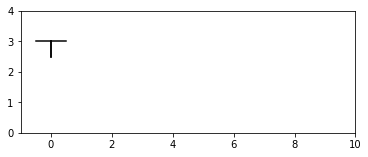

In [203]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,10])
    ax.set_ylim([0,4])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*sin(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB= m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value+m.q[i,'theta_ll'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb+m.len[('leg',2)]*sin(thB)    
    leg2_yb = leg1_yb+m.len[('leg',2)]*cos(thB)     
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [95]:
# for n in range(1,N+1):
#     print(m.q[i,'y'].value)